In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import plotly.io as pio
# Используем renderers для статического отображения графиков в ноутбуке
pio.renderers.default = 'png'


from tqdm import tqdm

    offers
    
    • ИД дома - идентификатор дома
    • ИД подъезда - идентификатор подъезда в доме (может быть несколько подъездов в 1 доме)
    • ИД квартиры - идентификатор квартиры в подъезде (может быть несколько квартир в 1 подъезде)
    • Лицевой счет (ЛС) - номер лицевого счета в квартире (может быть несколько в 1 квартире)
    • Услуга - услуга периодического обслуживания (может быть несколько услуг на 1 ЛС) 
    • Тариф - ставка тарифа в месяц по услуге, действующая на момент выгрузки данных.
    • Статус услуги - название статуса услуги. 
        ◦ Одновременно на одной квартире может быть только одна базовая услуга ТО МКД, ТО СВОД или ТО ДВЕРЬ в статусе! = Завершена. 
        ◦ Остальные услуги дополнительные и могут быть на одном ЛС с базовой или дополнительном ЛС на квартире. 
    • Дата начала услуги - дата начала действия услуги на ЛС. 
        ◦ Если на одном ЛС есть несколько базовых услуг (ТО МКД, ТО СВОД или ТО ДВЕРЬ), то ранее действующая должна быть в статусе Завершена. 

    payments
    
    • ЛС - номер лицевого счета
    • Сумма платежа - сумма платежа, поступившего на ЛС 
    • Дата загрузки - дата загрузки платежа в БД
    • Источник платежа - способ ввода платежа БД. Возможны возвраты платежей со знаком "-" и списания со знаком "+"
    • Способ оплаты - источник платежа (название платежной системы или оплат в офисе)
    • Комментарий к платежу - существенная информация по платежу 

ТЗ:

    1. Выполнить проверку данных в таблице лицевых счетов. Кратко описать суть проверки, результат проверки и предпринятый или предлагаемый способ устранение дефекта данных (если обнаружены артефакты). 
    2. Рассчитать для каждого ЛС сумму всех поступивших платежей с учетом возвратов, но исключая списания. 
    3. Рассчитать для каждого ЛС плановую выручку с учетом дат начала услуг на ЛС и ставки тарифа
    4. Рассчитать для каждого ЛС сальдо: плановая выручка (п. 3) минус сумма платежей (из п. 2).
    5. Рассчитать для каждой квартиры частоту платежей и количество оплаченных тарифов а календарный год.
    6. Предложите другие метрики для анализа платежной дисциплины абонентов за услуги.
    7. Визуализируйте метрики:
        a. в календарной динамике
        b. с акцентом на обнаруженные отклонения/аномалии

### EDA

In [2]:
offers = pd.read_excel('/home/the_rogue/TEST/Data/_offers.xlsx')
payments = pd.read_excel('/home/the_rogue/TEST/Data/_payments.xlsx')

In [3]:
offers.head(20)

,ИД дома,ИД подъезда,ИД квартиры,Лицевой счет (ЛС),Услуга,Ставка тарифа,Статус услуги,Дата начала услуги
0,100,1624,43036,43036,ТО МКД,5.2,Активна,2008-01-23
1,100,1624,43037,43037,ТО МКД,5.4,Активна,2008-01-23
2,100,1624,43038,43038,ТО МКД,5.2,Активна,2008-01-23
3,100,1624,43039,43039,ТО МКД,5.2,Активна,2008-01-23
4,100,1624,43040,43040,ТО МКД,5.2,Активна,2008-01-23
5,100,1624,43041,43041,ТО МКД,5.4,Активна,2008-01-23
6,100,1624,43042,43042,ВБ,4.5,Активна,2018-01-15
7,100,1624,43042,43042,ТО МКД,5.2,Активна,2010-07-01
8,100,1624,43043,43043,ТО МКД,5.4,Активна,2013-10-01
9,100,1624,43044,43044,ТО МКД,5.4,Активна,2008-01-23


In [4]:
offers.isna().sum()

ИД дома                 0
ИД подъезда             0
ИД квартиры             0
Лицевой счет (ЛС)       0
Услуга                  0
Ставка тарифа         227
Статус услуги           0
Дата начала услуги      0
dtype: int64

In [5]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49543 entries, 0 to 49542
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ИД дома             49543 non-null  int64         
 1   ИД подъезда         49543 non-null  int64         
 2   ИД квартиры         49543 non-null  int64         
 3   Лицевой счет (ЛС)   49543 non-null  int64         
 4   Услуга              49543 non-null  object        
 5   Ставка тарифа       49316 non-null  float64       
 6   Статус услуги       49543 non-null  object        
 7   Дата начала услуги  49543 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.0+ MB


In [6]:
payments.head(20)

,ЛС,Сумма платежа,Дата загрузки,Источник платежа,способ оплаты,Комментарий к платежу
0,1,4.8,2019-04-16,Ручной ввод,Офис,NaN
1,1,14.4,2018-10-17,Ввод из реестра,Сбербанк России,NaN
2,1,14.4,2019-01-21,Ввод из реестра,КС банк,NaN
3,1,32.4,2020-12-11,Ввод из реестра,КС банк,NaN
4,1,56.4,2018-02-09,Ввод из реестра,КС банк,NaN
5,1,60.0,2020-01-16,Ручной ввод,КС банк,Беговатов ВВ
6,2,-167.5,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
7,2,-144.0,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
8,2,-108.0,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
9,2,-108.0,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта


In [7]:
payments.isna().sum()

ЛС                            0
Сумма платежа                 0
Дата загрузки                 0
Источник платежа              0
способ оплаты                 0
Комментарий к платежу    350970
dtype: int64

In [8]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356846 entries, 0 to 356845
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ЛС                     356846 non-null  int64         
 1   Сумма платежа          356846 non-null  float64       
 2   Дата загрузки          356846 non-null  datetime64[ns]
 3   Источник платежа       356846 non-null  object        
 4   способ оплаты          356846 non-null  object        
 5   Комментарий к платежу  5876 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 16.3+ MB


In [9]:
offers.shape, payments.shape

((49543, 8), (356846, 6))

In [10]:
offers.duplicated().sum(), payments.duplicated().sum()

(0, 585)

В одном из датасетов видно наличие дубликатов в заполнении таблицы, подчистим их

In [11]:
payments = payments.drop_duplicates()
payments = payments.reset_index(drop=True)

In [12]:
payments.duplicated().sum()

0

Теперь обе наши таблички очищенны от повторяющихся строк

Для удобства дальнешего анализа добавим в табличку offers столбцы с годом и месяцем:

In [13]:
offers['Год'] = offers['Дата начала услуги'].dt.year
offers['Месяц'] = offers['Дата начала услуги'].dt.month


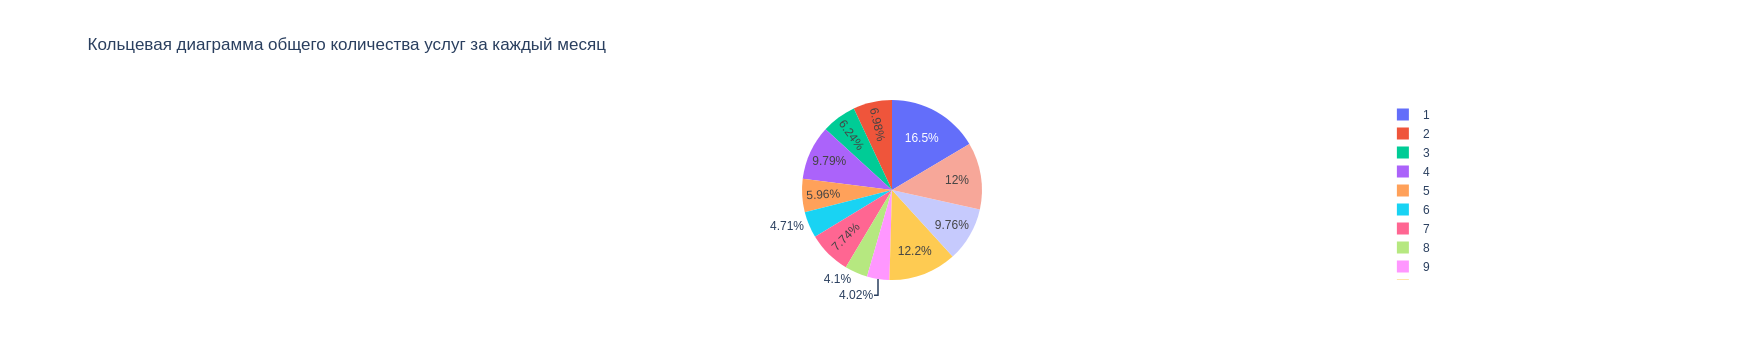

In [14]:
fig = go.Figure()
fig.add_trace(go.Pie(values=offers['Месяц'].value_counts().sort_index(ascending=True), 
                     labels=offers['Месяц'].value_counts().sort_index(ascending=True).index, 
                     sort = False))
fig.update_layout(title="Кольцевая диаграмма общего количества услуг за каждый месяц")
# Сохранение статического изображения в формате PNG
fig.write_image("static_plot.png")
fig.show()

In [15]:
print('Количество услуг за каждый месяц: \n', offers['Месяц'].value_counts().sort_index(ascending=True))

Количество услуг за каждый месяц: 
 Месяц
1     8162
2     3459
3     3091
4     4852
5     2954
6     2332
7     3834
8     2030
9     1994
10    6058
11    4835
12    5942
Name: count, dtype: int64


Анализ общей потребительской активности пользователей

Исходя из анализа диаграммы, можно сделать следующие следующие выводы.
- Самая большая активность пользователей по разного рода заявкам приходится на январь месяц и составляет (16,5% из 100%). Гипотеза: Данные показатели связанны с наступлением Нового года, у людей появляется свободное время в праздничные дни, а так же с тем, что они стремятся совершать новые начинания.
- Далее по ативности идут такие месяцы как октябрь (12,2%) и декабрь( 12%). Гипотеза: Предположительно показатели в декабре связанны, так же с приближением Нового года, чать людей стремиться закончить дела в уходящем году, а не переносить их на новый. Активнсть октября скорее всего связанана с ухудшением погодных условий, люди больше времяни проводят дома и хотят чувствовать себя в безопасности.
-Следущие по активности идут такие месяца как ноябрь (9,76%) и апрель (9,79%). Гипотеза: ноябрь связан с ухудшением погодных условий и увелечением времяни нахожденения пользователей в квартирах, апрель возможно связан с тем, что люди хотят закончить свои дела, до наступления майских праздников. 
-Дальше по активности идут такие месяца как февраль (6,98%), март (6,24%) июль( 7,74%) и май (5,96%).Показатели имеют  средний диапазон значений. 
-Самые маленькая активность пользователей наблюдается в июне( 4, 71%) августе (4,1%) и сентябре (4,02%). Гипотеза: причиной этому в летнии месяцы является улучшение погоды, люди больше проводят времяни на улице, в июле наступает небольшое увечение скорее всего из-за жары, тогда как низкие показатели сентября возможно связанны с выходом многих людей на работу из отпусков и наступлением школьного периода у детей, что повышает загруженость родителей.

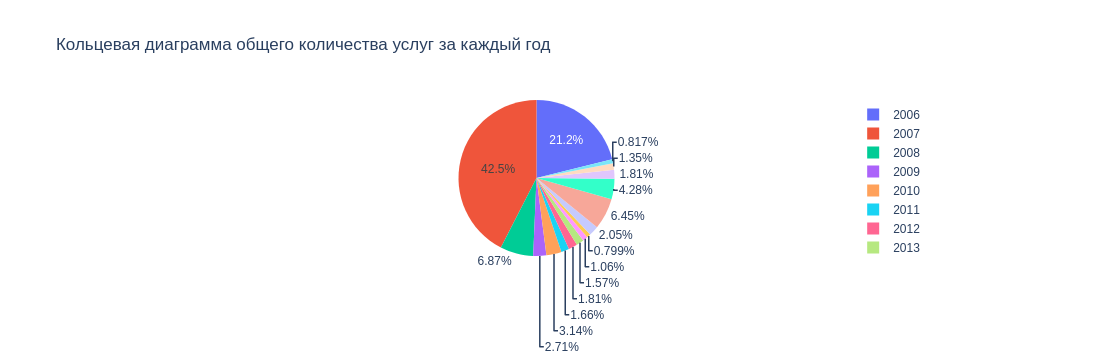

In [16]:
fig = go.Figure()
fig.add_trace(go.Pie(values=offers['Год'].value_counts().sort_index(ascending=True), 
                     labels=offers['Год'].value_counts().sort_index(ascending=True).index, 
                     sort = False))
fig.update_layout(title="Кольцевая диаграмма общего количества услуг за каждый год")
# Сохранение статического изображения в формате PNG
fig.write_image("static_plot2.png")
fig.show()

In [17]:
print('Количество услуг за каждый год: \n', offers['Год'].value_counts().sort_index(ascending=True))

Количество услуг за каждый год: 
 Год
2006    10481
2007    21032
2008     3403
2009     1343
2010     1558
2011      824
2012      899
2013      778
2014      526
2015      396
2016     1016
2017     3195
2018     2119
2019      899
2020      669
2021      405
Name: count, dtype: int64


Анализ общей потребительской активности за каждый год.
-Самая большая ативность наблюдается в 2007 году ( 42,7%) и 2006 году (21,2%) Гипотеза: Скорее всего это связанно с тем, что в этих годах это направление было на пике своей популярности и являлось новинкой для многих многоквартирных домов, особенно старого образца. Количество спроса было огромным. 
-Далее по показателям идёт 2008 год (6,87%) и 2017 год (6,45%) Гипотеза: 2008 году количество спроса начало падать, из-за уменьшения количества домов в которых не было домафона, а также скорее всего из-за увелечения конкуренции со стороны других компаний. Количество компаний по оказанию этих услуг росло, а количество домов нуждающихся в этой услуге уменьшалось. Увелечения же спроса в 2017 году, возможно было связанно с масовым строительством новых многоэтажек и тем самым увелечением количества спроса.  
- Далее по активности идут 2009 год ( 2,71%); 2010 год ( 3,14%) и 2018 год ( 4,28%). Гипотеза: Скорее всего в эти периоды тоже ативно стоились новые многоквартирные дома в разных городах Росии. 
- Далее по активности идёт период с 2011-2016 год. В этот период спрос на услуги в данной области значительно упал и находился в диапозоне от (0,799% до 2,05%). Гипотеза: это связанно с уменьшением строительства новых многоквартирных домов.
-В отедельную категорию можно отнести последнии три года начиная 2019-2021 год. В эти года спрос на данные услуги снова резко упал и находился в диапозоне от ( 0,817% до 1,81%). Гипотеза: Это может быть связанно с наступлением неспокойного периода в мире, тоесть началом эпидемии короновируса. 

In [18]:
### уникальные значения статусов услуг
offers['Статус услуги'].unique()

array(['Активна', 'Завершена', 'Не предоставляется', 'Отказ',
       'Приостановлена', 'Не обслуживается', 'Будет активна'],
      dtype=object)

In [19]:
### количество по каждому статусу
offers['Статус услуги'].value_counts()

Статус услуги
Активна               39065
Завершена              5976
Не предоставляется     2979
Отказ                  1451
Приостановлена           70
Не обслуживается          1
Будет активна             1
Name: count, dtype: int64

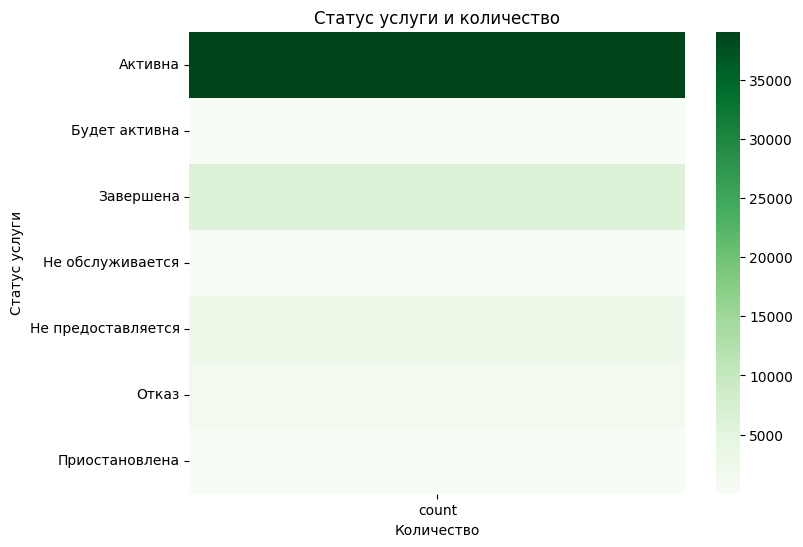

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(offers['Статус услуги']
            .value_counts()
            .sort_index(ascending=True)
            .reset_index()
            .rename(columns={'index': 'Месяц'})
            .set_index('Статус услуги'), cmap='Greens')
plt.xlabel('Количество')
plt.ylabel('Статус услуги')
plt.title('Статус услуги и количество')
plt.show()

In [21]:
offers.query("`Статус услуги` == 'Будет активна' or `Статус услуги` == 'Не обслуживается'")

,ИД дома,ИД подъезда,ИД квартиры,Лицевой счет (ЛС),Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц
6223,753,1035,30461,30461,ТО МКД,5.4,Не обслуживается,2007-04-10,2007,4
10618,1365,62,2506,2506,ТО Дверь,NaN,Будет активна,2021-11-01,2021,11


Как видим из таблицы выше с двумя этими квартирами идет процесс работы, предложу разобраться с квартирой в статусе "Не обслуживается" и после уточнения вопроссов перевести ее статус в "Не предоставляется" или "Завершена", в зависимости от результатов работы по данной точке.

Вторую квартиру в статусе "Будет активна" нужно так же или довести до статуса "Активна" или, уточнив детали, так же перевести в статус "Не предоставляется" / "Не обслуживается" или иной другой статус за исключением тех, которые мы наблюдаем в обозреваемой табличке выше.

Так же в квартире со статусом "Будет активна" отсутствует тарифная ставка, предположу что по причине недоговоренности с клиентом по тарифу(или он просто еще его не выбрал) из-за того, что услуга фактически ему еще не предоставляется и, возможно, только будет активна в будующем промежутке времени.

In [22]:
offers[offers['ИД дома'] == 1365]['Ставка тарифа'].unique()

array([5.4, 5. , 4.5, 5.2, nan, 4.7])

In [23]:
offers[offers['ИД дома'] == 1365]['Услуга'].unique()

array(['ТО МКД', 'ТО СВОД', 'ВБ', 'ТО Дверь'], dtype=object)

Видим различные тарифы и услуги даже для одного дома, как следствие - это подтверждает нашу гипотезу, описанную выше.

In [24]:
### Посмотрим сколько тарифных планов предоставляется по каждой из услуг
offers.groupby('Услуга')['Ставка тарифа'].nunique()

Услуга
ВБ                         4
Рассрочка за Апгрейд ВБ    0
Рассрочка за Монтаж ВБ     0
ТО Дверь                   6
ТО МКД                     8
ТО СВОД                    5
Name: Ставка тарифа, dtype: int64

In [25]:
offers[offers['Услуга'] == 'ВБ']['Ставка тарифа'].unique()

array([4.5, 5. , 4. , 9.7])

In [26]:
offers[offers['Услуга'] == 'ВБ']['Ставка тарифа'].median()

4.5

<Axes: ylabel='Ставка тарифа'>

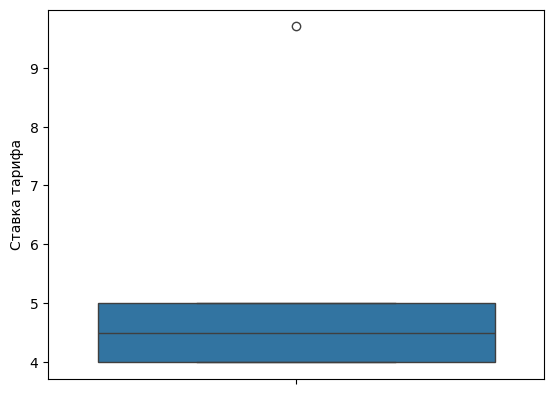

In [27]:
sns.boxplot(offers[offers['Услуга'] == 'ВБ']['Ставка тарифа'])

Видно, что в рассрочках услуг нет ни одного тарифного плана

In [28]:
(
    offers.query("`Услуга` == 'Рассрочка за Монтаж ВБ' or `Услуга` == 'Рассрочка за Апгрейд ВБ'")['Ставка тарифа'].unique(),
    offers.query("`Услуга` == 'Рассрочка за Монтаж ВБ' or `Услуга` == 'Рассрочка за Апгрейд ВБ'")['Ставка тарифа'].shape
)

(array([nan]), (223,))

Теперь понятно по какой причине в наших данных такое количество пропусков - это связанно с тем, что у этих клиентов действует рассрочка по тарифам, предлогаю все эти пропуски объединить в один отдельный тариф(опять же для удобства анализа), к примеру тариф будет называться "-10."

In [29]:
offers.loc[(
    (offers['Услуга'] == 'Рассрочка за Монтаж ВБ') | 
    (offers['Услуга' ] == 'Рассрочка за Апгрейд ВБ')), 
    ['Ставка тарифа']] = (
    offers.loc[(
        (offers['Услуга'] == 'Рассрочка за Монтаж ВБ') | 
        (offers['Услуга' ] == 'Рассрочка за Апгрейд ВБ')), 
        ['Ставка тарифа']]
        .fillna(-10.)
)

In [30]:
offers.isna().sum()

ИД дома               0
ИД подъезда           0
ИД квартиры           0
Лицевой счет (ЛС)     0
Услуга                0
Ставка тарифа         4
Статус услуги         0
Дата начала услуги    0
Год                   0
Месяц                 0
dtype: int64

Однако у нас еще осталось 4 пропущенных значения, хотя большую часть пропусков мы уже смогли заполнить.

In [31]:
### посмотрим на них по ближе
offers[offers['Ставка тарифа'].isna()]

,ИД дома,ИД подъезда,ИД квартиры,Лицевой счет (ЛС),Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц
3605,632,1242,34945,48222,ТО МКД,NaN,Завершена,2010-01-01,2010,1
10618,1365,62,2506,2506,ТО Дверь,NaN,Будет активна,2021-11-01,2021,11
45067,5108,1463,39540,39540,ТО Дверь,NaN,Не предоставляется,2018-11-01,2018,11
47093,5165,1768,46177,48399,ТО МКД,NaN,Завершена,2010-07-01,2010,7


Как видно это уже старые данные (исходя из года) или уже наша знакомая выше квартира со статусом "Будет активна", так же одна из услуг просто не предоставляется по указанной квартире, поэтому в ней тоже нет тарифной ставки.

In [32]:
offers.query("`Год` == 2010 and `Услуга` == 'ТО МКД'")['Ставка тарифа'].unique()

array([5.2, 5.4, 4.5, nan, 5.6, 5. , 4.3])

In [33]:
offers.query("`Год` == 2010 and `Услуга` == 'ТО МКД'").describe(include=['bool', 'object'])

,Услуга,Статус услуги
count,1558,1558
unique,1,5
top,ТО МКД,Активна
freq,1558,1143


<Axes: ylabel='Ставка тарифа'>

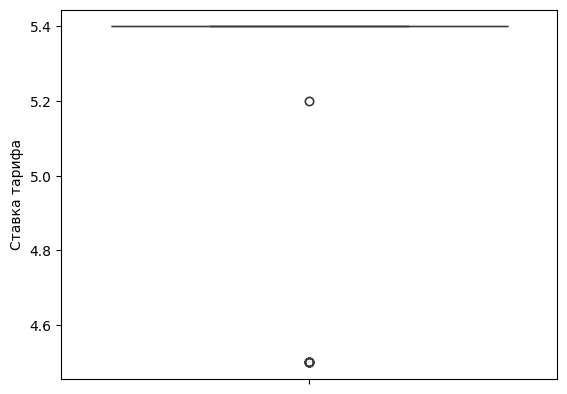

In [34]:
sns.boxplot(offers.query("`Год` == 2010 and `Услуга` == 'ТО МКД' and `Статус услуги` == 'Завершена'")['Ставка тарифа'])

In [35]:
offers.query("`Год` == 2010 and `Услуга` == 'ТО МКД' and `Статус услуги` == 'Завершена'").shape

(232, 10)

In [36]:
offers.query("`Год` == 2010 and `Услуга` == 'ТО МКД' and `Статус услуги` == 'Завершена'")['Ставка тарифа'].median()

5.4

предлагаю два пропуска от 2010 года заполнить медианным значением по этому году, для данной услуги и статуса

In [37]:
offers.loc[(
    (offers['Год'] == 2010) & 
    (offers['Услуга' ] == 'ТО МКД') &
    (offers['Статус услуги' ] == 'Завершена')), 
    ['Ставка тарифа']] = (
        offers.loc[(
    (offers['Год'] == 2010) & 
    (offers['Услуга' ] == 'ТО МКД') &
    (offers['Статус услуги' ] == 'Завершена')), 
    ['Ставка тарифа']].fillna(offers
                              .query("`Год` == 2010 and `Услуга` == 'ТО МКД' and `Статус услуги` == 'Завершена'")
                              ['Ставка тарифа']
                              .median())
    )

In [38]:
offers[offers['Ставка тарифа'].isna()]

,ИД дома,ИД подъезда,ИД квартиры,Лицевой счет (ЛС),Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц
10618,1365,62,2506,2506,ТО Дверь,NaN,Будет активна,2021-11-01,2021,11
45067,5108,1463,39540,39540,ТО Дверь,NaN,Не предоставляется,2018-11-01,2018,11


In [39]:
offers.query("`Год` == 2018 and `Услуга` == 'ТО Дверь' and `Статус услуги` == 'Не предоставляется'").shape

(155, 10)

In [40]:
offers.query("`Год` == 2018 and `Услуга` == 'ТО Дверь' and `Статус услуги` == 'Не предоставляется'")['Ставка тарифа'].median()

5.0

Предлогаю по аналогии поступить с пропуском, где в статусе услуги стоит "Не предоставляется"

In [41]:
offers.loc[(
    (offers['Год'] == 2018) & 
    (offers['Услуга' ] == 'ТО Дверь') &
    (offers['Статус услуги' ] == 'Не предоставляется')), 
    ['Ставка тарифа']] = (
        offers.loc[(
    (offers['Год'] == 2018) & 
    (offers['Услуга' ] == 'ТО Дверь') &
    (offers['Статус услуги' ] == 'Не предоставляется')), 
    ['Ставка тарифа']].fillna(offers
                              .query("`Год` == 2018 and `Услуга` == 'ТО Дверь' and `Статус услуги` == 'Не предоставляется'")
                              ['Ставка тарифа']
                              .median())
    )

In [42]:
offers[offers['Ставка тарифа'].isna()]

,ИД дома,ИД подъезда,ИД квартиры,Лицевой счет (ЛС),Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц
10618,1365,62,2506,2506,ТО Дверь,NaN,Будет активна,2021-11-01,2021,11


In [43]:
offers[offers['Услуга'] == 'ТО Дверь']['Ставка тарифа'].median()

5.2

У нас остался последнее пропущенное значение в уже знакомой нам квартире

In [44]:
offers['Ставка тарифа'] = offers['Ставка тарифа'].fillna(offers[offers['Услуга'] == 'ТО Дверь']['Ставка тарифа'].median())

In [45]:
### Суммарное количество пропусков
offers.isna().sum().sum()

0

Наш датасет предварительно почищен и можно приступать к его более углубленному анализу

Для начала бегло взгянем на графики

<Figure size 10000x3000 with 0 Axes>

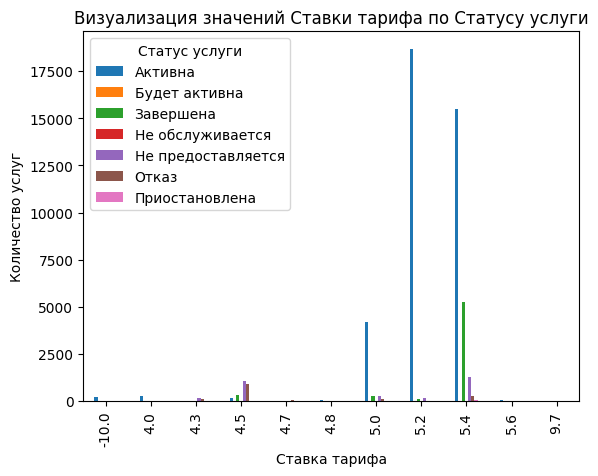

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(100,30))
pd.crosstab(offers['Ставка тарифа'], offers['Статус услуги']).plot(kind='bar', stacked=False)
plt.xlabel('Ставка тарифа')
plt.ylabel('Количество услуг')
plt.title('Визуализация значений Ставки тарифа по Статусу услуги')
plt.show()

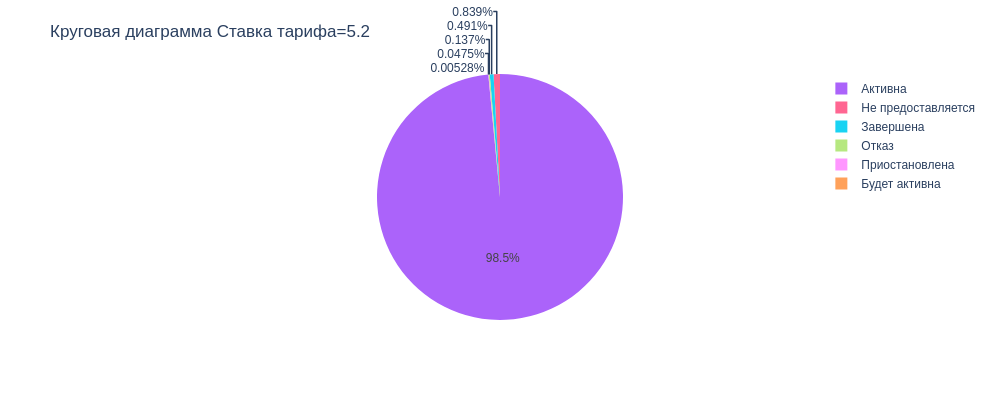

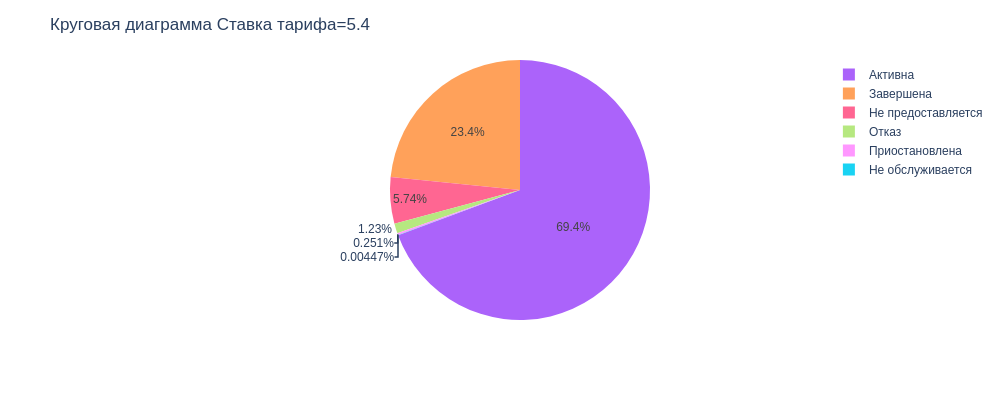

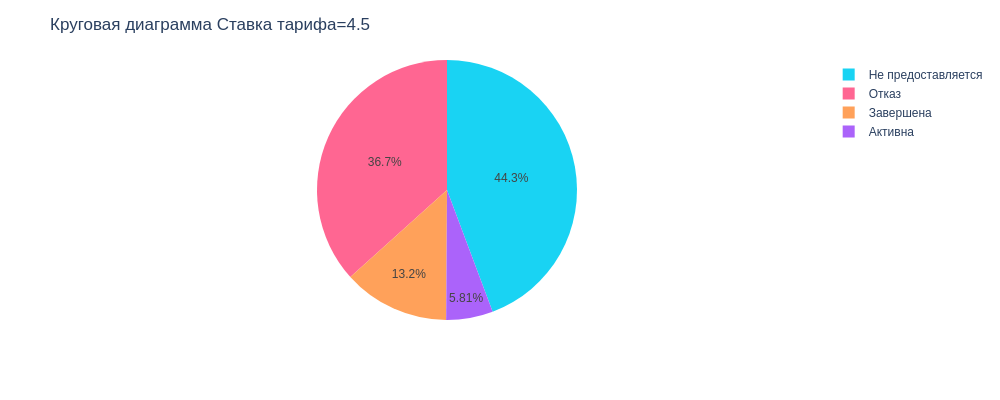

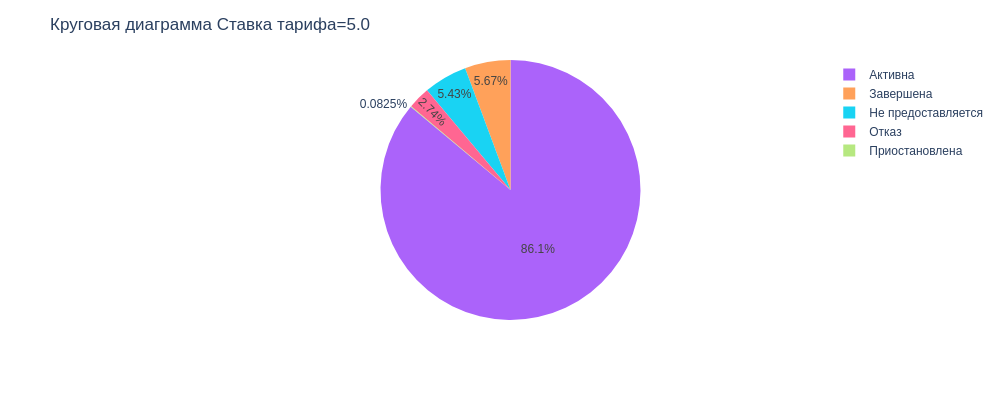

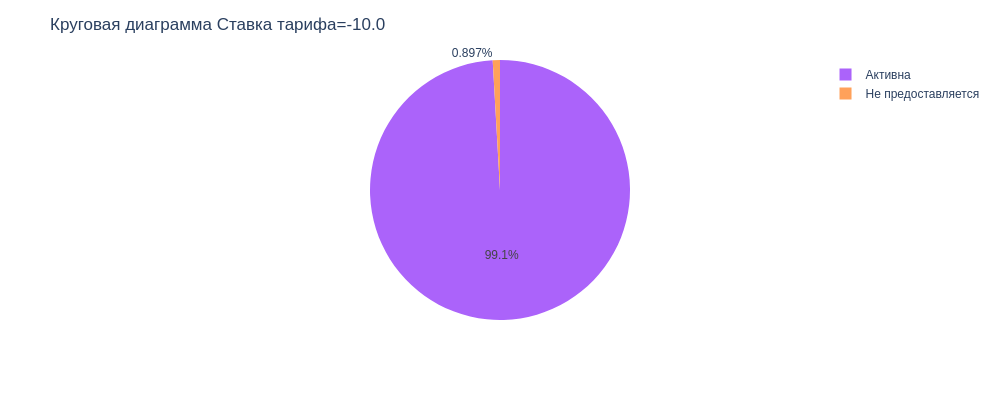

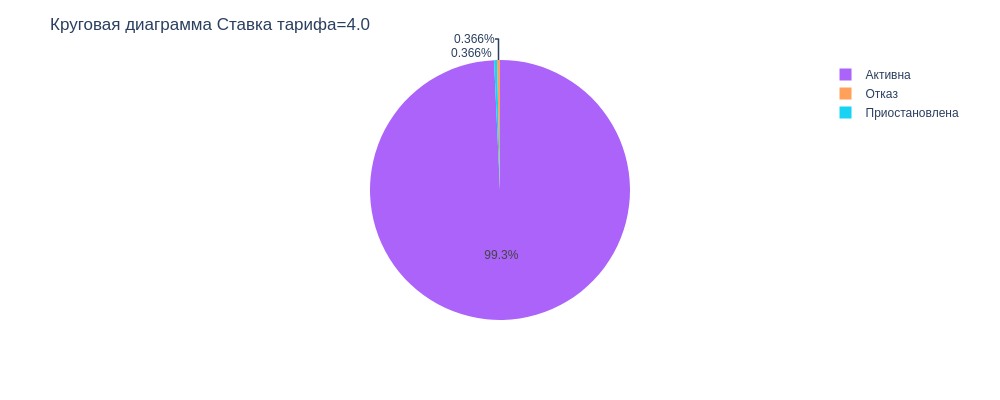

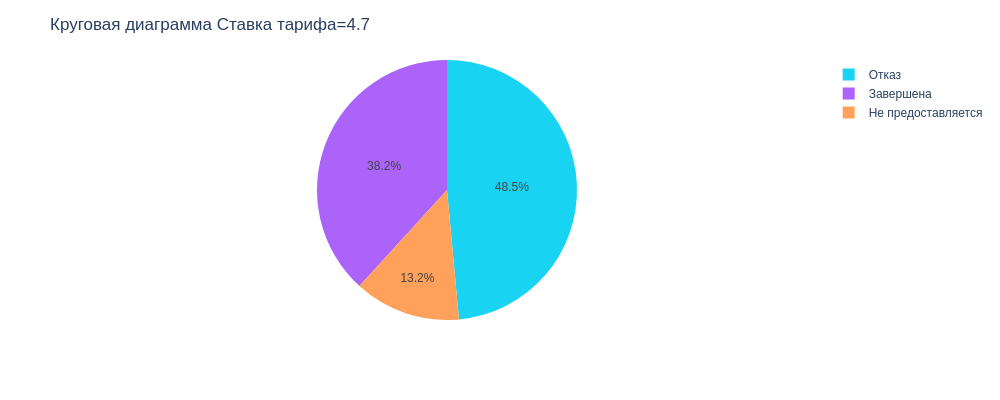

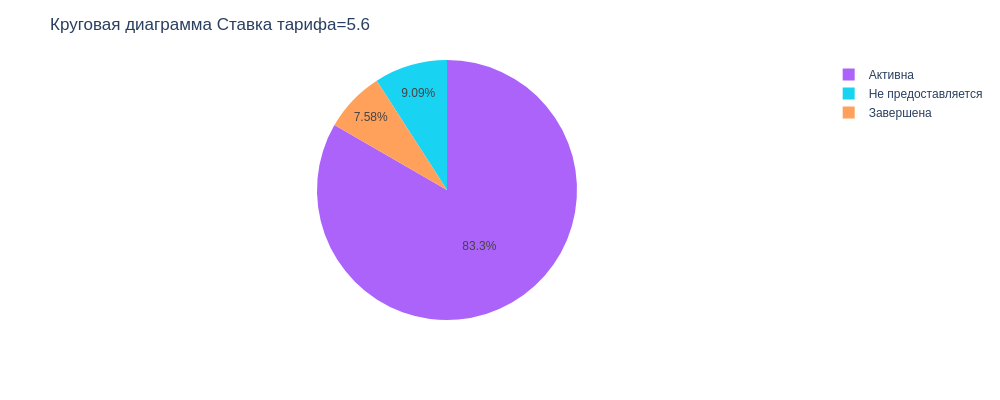

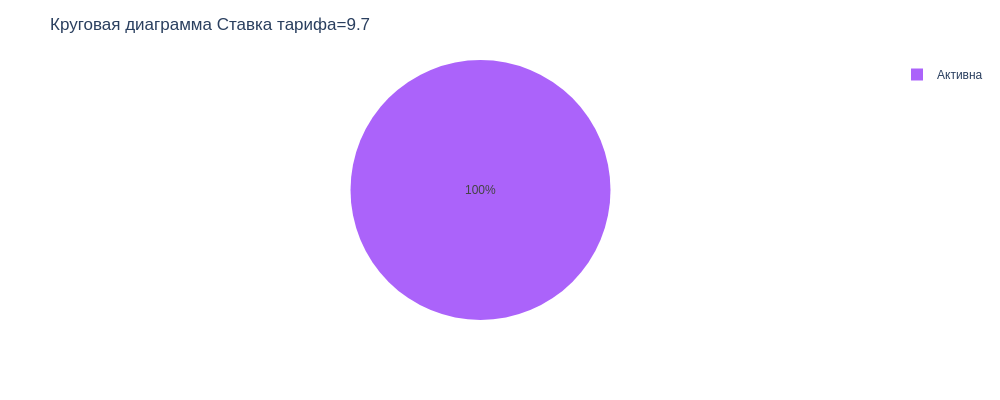

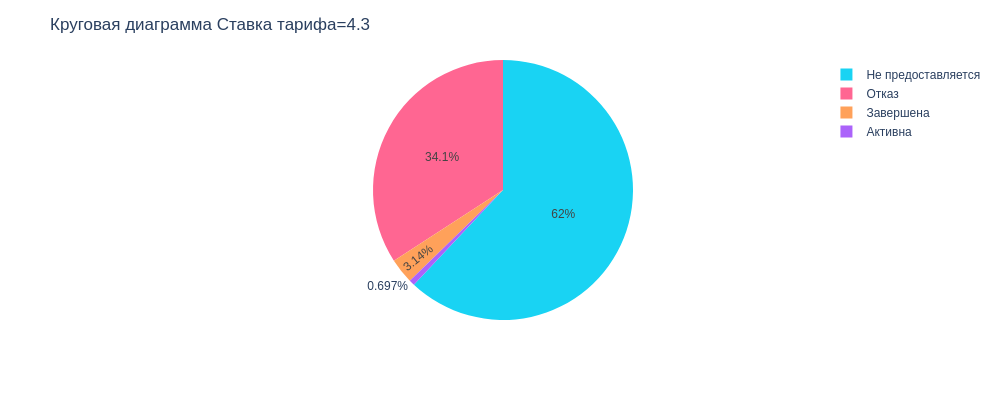

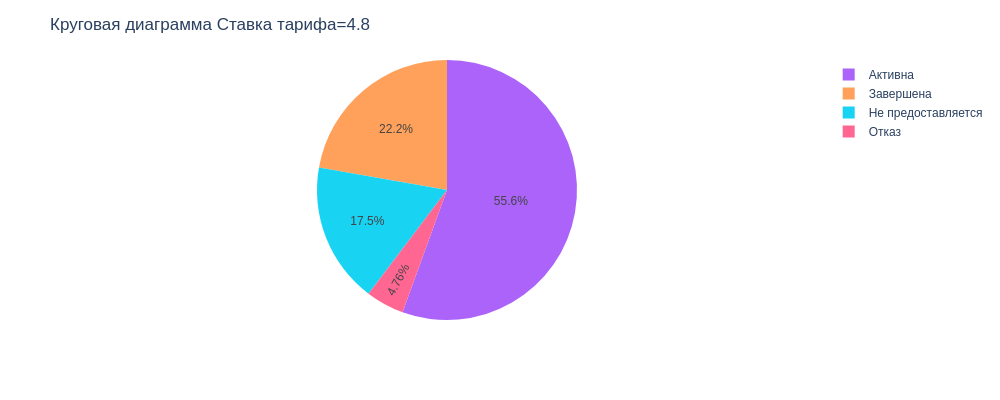

In [136]:

for tariff in offers['Ставка тарифа'].unique():
    subset = offers[offers['Ставка тарифа'] == tariff]
    
    # Создание таблицы сопряженности
    crosstab_data = pd.crosstab(subset['Ставка тарифа'], subset['Статус услуги'])
    
    # Преобразование таблицы в формат, подходящий для круговой диаграммы
    data = crosstab_data.stack().reset_index(name='Количество услуг').rename(columns={'Статус услуги': 'Статус услуги'})
    
    # Добавление информации о годе в таблицу данных
    data['Год'] = subset['Год'].iloc[0]
    
    # Построение круговой диаграммы с добавлением цвета по году
    fig = px.pie(data, names='Статус услуги', values='Количество услуг', color='Статус услуги', 
                 color_discrete_map={'статус1': 'rgb(31, 119, 180)', 'статус2': 'rgb(255, 127, 14)', 'статус3': 'rgb(44, 160, 44)'})
    
    # Установка размеров
    fig.update_layout(width=1000, height=400, title=f'Круговая диаграмма Ставка тарифа={tariff}')
    

    # Сохранение статического изображения в формате PNG
    fig.write_image(f"static_plot{tariff}.png")
    
      # Отображение графика внутри ячейки вывода
    fig.show()

Анализ значений ставки тарифа по статусу услуги.
- Тариф под кодовым названием (-10.0) включает в себя показатели рассрочки на услуги. Активен у 221 пользователя, что составляет 98,7% из 100%. У 2 пользователей тариф находится в статусе ( не предаставялется), что составляет 0,893% из 100%. У 1 пользователя тариф находится в статусе ( будет активен).
 
- Тариф под кодовым названием (4.0) активен у 271 пользователя, что составляет 99,3% из 100%, отказался от тарифа 1 пользователь и еще 1 приостановил тариф.

- Тариф под  кодовым названием (4.3) активен только у 2 пользователей, что составляет (0,697% из 100%). У 178 пользователя тариф находится в статусе (Не предоставляется) , что составляет 62% из 100%. У 98 пользователей тариф находится в статусе ( отказ), что составляет 34,1% из 100%. У 9 пользователей тариф находится в статусе (завершен), что составляет 3,14% из 100%.

- Тариф под кодовым названием (4.5) активен у 140 пользователей, что составляет 5,81% из 100%. У 1067 польвателей тариф находится в статусе ( не предоставляется), что составляет 44,3% из 100%. У 883 пользователей данный тариф находится в статусе (отказ), что составляет 36,7% из 100%. У 319 пользователя тариф находится в статусе ( завершен), что составляет 13,2% из 100%.

- Тариф под кодовым названием (4.7) не имеет активных пользователей. У 33 пользователей тариф находится в статусе(отказ), что составляет 48,5% из 100%. У 26 пользователей, тариф находится в статусе ( завершен), что составляет 38,2% из 100%. У 9 пользователей данный тариф находится в статусе ( не предоставляется), что составлялет 13,2% из 100%.

- Тариф под кодовым названием (4.8) активен у 35 пользователей, что составляет 55,6% из 100%. У 14 пользователей тариф находится в статусе (завершен), что состаялет 22,2% из 100%. У 11 пользователей тариф находится в статусе ( не предоставялется), что составляет 17,5% из 100%. У 3 пользователей тариф находится в статусе ( отказ), что составляет 4,76% из 100%. 

- Тариф под кодовым названием (5.0) активен у 4171 пользователя, что составялет 86,1% из 100%. У 275 пользователей тариф находится в статусе ( завершен) , что состаляет 5,67% из 100%. У 263 пользователей данный тариф находится в статусе ( не предоставляется), что составляет 5,43% из 100%. У 133 пользователей тариф находится в статусе (отказ), что составляет 2,74% из 100%. У 4 пользователей тариф находится в статусе ( приостановлен), что составлялет 0,0825% из 100%.

- Тариф под кодовым названием (5.2) активен у 18667 пользователей, что составляет 98,5% из 100%. У 159 пользователя данный тариф находится в статусе ( не предоставляется), что составляет 0,839% из 100%. У 93 пользователей, данный тариф находится в статусе (завершен), что составляет 0,491% из 100%. У 26 пользователей тариф находится в статусе ( отказ), что состаялет 0,137% из 100%. У 9 пользователей тариф находится в статусе ( приостановлен), что составляет 0,0475% из 100%. 

- Тариф под кодовым названием (5.4) активен у 15502 пользователей, что составляет 69,4% из 100%. У 5235 пользователей данный тариф находится в статусе ( завершен), что состаялет 23,4% из 100%. У 1284 пользователей тариф находится в статусе ( не предоставляется), что составляет 5,74% из 100%. У 274 пользователей тариф находится в статусе (отказ), что составялет 1,23% из 100%. У 56 пользователей данный тариф находится в статусе ( приостановлен), что составляет 0,251% из 100%. у 1 пользователя тариф находится в статусе ( не обслуживается). 

- Тариф под кодовым названием (5.6) активен у 55 пользователей , что составляет 83,3% из 100%. У 6 пользователей тариф находится в статусе ( не предоставялется) , что составялет 9,09% из 100%. У 5 пользователей тариф находится в статусе
(завершен), что составляет 7,58% из 100%. 
  
- Тариф под кодовым названием (9.7) активен только у 1 пользователя, что составялет 100% из 100%. 

Вывод: 
- Исходя из анализа данных, самым популярным тарифом компании является тариф (5.2) общее число его ативных пользователей составялет 18667.
- Второе место по популярности занимает тариф (5.4) общеее число его активных пользователей состаялет 15502, что на 3165 пользователей меньше, чем у первого тарифа. 
- Третье место по популярности занимает тариф (5.0) общее число активных пользователей составляет 4171, что на 14496 тысяч меньше, чем у самого популярного тарифа. 

Вывод:

- Самым не популярным тарифом является тариф (9.7), он ативен только у одного пользователя.
- Второе место в нашем отрицательном рейтинге занимает тариф (4.2) у него есть только 2 активных пользователя. 
- Третье место занимает тариф (4.8), он активен только 35 пользователей. 

Отдельно можно вынести тариф (4.7) он вообще не имеет активных пользователей, но имеет определенный процент отказов от него. Из этого можно сделать вывод, что 100% пользователям, что подключали его, он в дальнейшем не понравился.

In [48]:
print(f'количество уникальных лицевых счетов: {len(offers["Лицевой счет (ЛС)"].unique())}; \nобщее количество обработанных заявок: {offers.shape[0]}')

количество уникальных лицевых счетов: 42531; 
общее количество обработанных заявок: 49543


<Axes: >

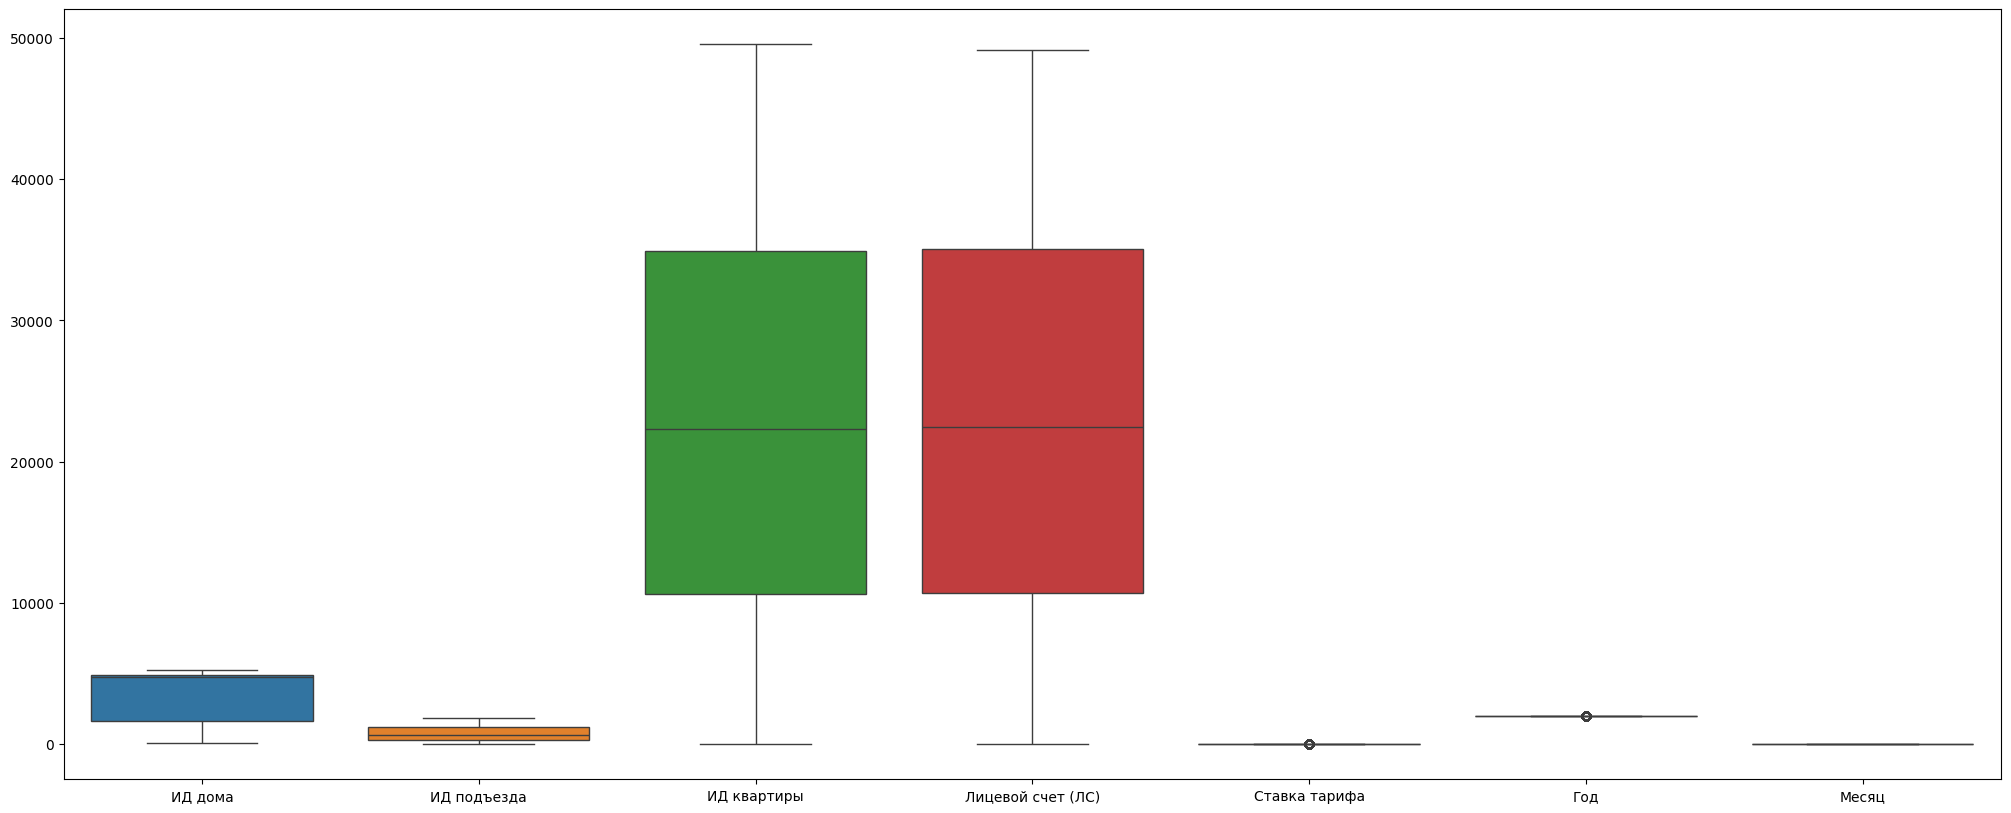

In [49]:
plt.figure(figsize=(25,10))
sns.boxplot(offers)

<Axes: ylabel='Ставка тарифа'>

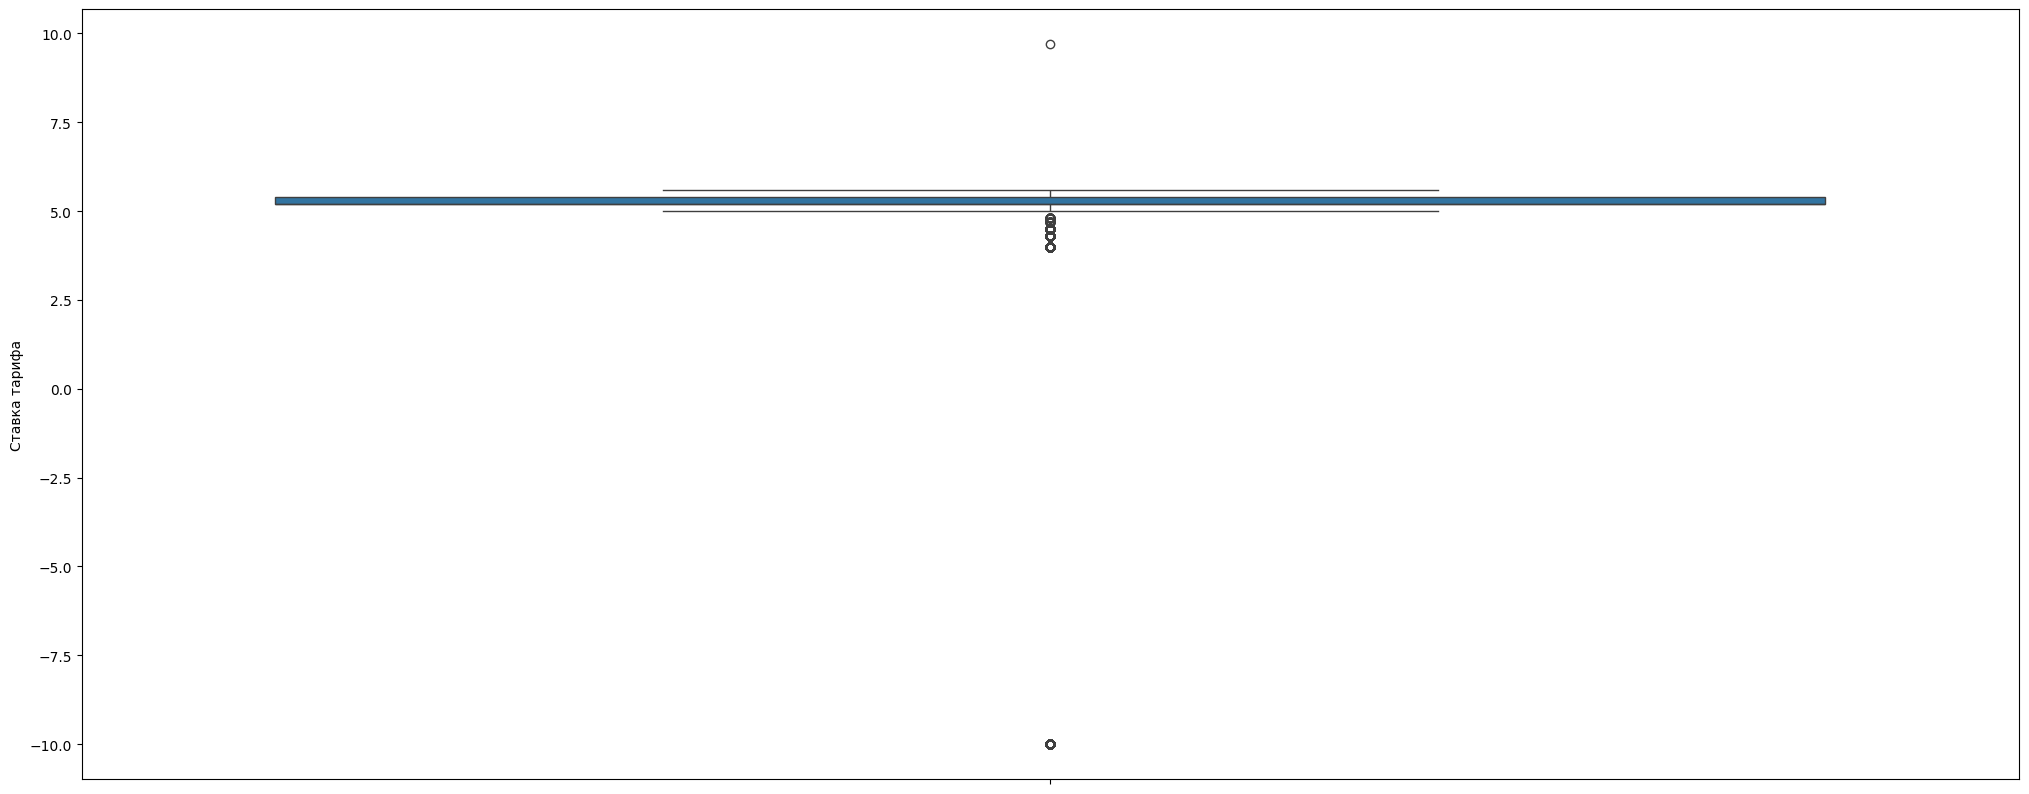

In [50]:
plt.figure(figsize=(25,10))
sns.boxplot(offers['Ставка тарифа'])

Видим нормальное распределение в данных, так же заметно маленькую выборку по годам и тарифным планам или это возможные пути для роста и развития компании, но это не относится к теме нашего исследования сейчас.

Так же выделяется наш новый тариф "-10.", для большего удобства и вектора развития с клиентами к нему относящимся

### Приступим к проверки данных:

Одновременно на одной квартире может быть только одна базовая услуга ТО МКД, ТО СВОД или ТО ДВЕРЬ в статусе! = Завершена.

In [51]:
### Сформируем выборку по требуемым услугам
question_status = (
    offers
    .query("`Услуга` == 'ТО МКД' or `Услуга` == 'ТО СВОД' or `Услуга` == 'ТО Дверь'")
    .sort_values(by='ИД квартиры')
    .reset_index(drop=True)
)

In [52]:
question_status.head(20)

,ИД дома,ИД подъезда,ИД квартиры,Лицевой счет (ЛС),Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц
0,1662,1,1,1,ТО Дверь,5.0,Завершена,2020-01-01,2020,1
1,1662,1,1,1,ТО МКД,5.2,Активна,2021-03-01,2021,3
2,1662,1,1,1,ТО МКД,5.4,Завершена,2006-09-02,2006,9
3,1662,1,2,2,ТО МКД,5.2,Активна,2007-10-01,2007,10
4,1662,1,3,3,ТО МКД,5.4,Активна,2006-09-02,2006,9
5,1662,1,4,4,ТО МКД,5.2,Активна,2006-09-02,2006,9
6,1662,1,5,5,ТО МКД,5.4,Активна,2006-09-02,2006,9
7,1662,1,6,6,ТО МКД,5.2,Активна,2006-09-02,2006,9
8,1662,1,7,7,ТО МКД,5.2,Активна,2006-09-02,2006,9
9,1662,1,8,8,ТО МКД,5.2,Активна,2006-09-02,2006,9


In [53]:
### Напишем функцию, которая будет проверять условие и возвращать неудовлетворяющие значения
def chek_fff(data = question_status):
    """
    """
    _list = []
    df = pd.DataFrame(columns=list(data.columns))
    df_2 = pd.DataFrame(columns=list(data.columns))

    for i in list(data['ИД квартиры'].unique()):
        df = data[data['ИД квартиры'] == i].sort_values(by='Статус услуги').reset_index(drop=True)
        if df.shape[0] > 1:
            for x in list(df['Статус услуги'].value_counts().index):
                if x != 'Завершена' and df['Статус услуги'].value_counts()[x] != 1:
                    if i not in _list:
                        
                        _list.append(i)

    return _list

In [54]:
chek_fff()

[]

In [55]:
### this better
def chek_fff(data=question_status):
    _list = []

    for i in data['ИД квартиры'].unique():
        subset = data[data['ИД квартиры'] == i].sort_values(by='Статус услуги').reset_index(drop=True)

        if subset.shape[0] > 1:
            for status in subset['Статус услуги'].unique():
                if status != 'Завершена' and (subset['Статус услуги'] == status).sum() > 1:
                    if i not in _list:
                        _list.append(i)

    return _list

In [56]:
chek_fff()

[]

In [57]:
### примечание - оставлю обе функции для обозрения, но вторая итоговая и по сути цель у них одинаковая.

Как видим условие выполняется и артефакты не обнаруженны.

Остальные услуги дополнительные и могут быть на одном ЛС с базовой или дополнительном ЛС на квартире.

(не вижу нарушения логики, все хорошо и ничего не нужно для этого проверять).

Если на одном ЛС есть несколько базовых услуг (ТО МКД, ТО СВОД или ТО ДВЕРЬ), то ранее действующая должна быть в статусе Завершена.

In [58]:
# Создаем пустой список для хранения Лицевых счетов, где условие не выполняется
_list = []

# Итерируемся по уникальным значениям 'Лицевой счет (ЛС)'
for ls in question_status['Лицевой счет (ЛС)'].unique():
    # Фильтруем данные только для текущего 'Лицевой счет (ЛС)'
    subset = question_status[question_status['Лицевой счет (ЛС)'] == ls].sort_values(by='Год').reset_index(drop=True)
    
    # Получаем уникальные значения 'Услуга'
    unique_services = subset['Услуга'].unique()
    
    # Проверяем, что в уникальных услугах есть более одной базовой услуги
    if sum(service in {'ТО МКД', 'ТО СВОД', 'ТО ДВЕРЬ'} for service in unique_services) > 1:
        # Проверяем, что все предшествующие услуги имеют статус 'Завершена'
        if all(subset[subset['Услуга'] == service].iloc[:-1]['Статус услуги'].eq('Завершена').all() for service in {'ТО МКД', 'ТО СВОД', 'ТО ДВЕРЬ'}):
            continue
        else:
            _list.append(ls)

print("Лицевые счета, где условие не выполняется:", _list)

Лицевые счета, где условие не выполняется: []


Вывод - данных артефактов наш датасет тоже не имеет.

### Метрики:

Рассчитать для каждого ЛС сумму всех поступивших платежей с учетом возвратов, но исключая списания.

In [59]:
payments.head(20)

,ЛС,Сумма платежа,Дата загрузки,Источник платежа,способ оплаты,Комментарий к платежу
0,1,4.800,2019-04-16,Ручной ввод,Офис,NaN
1,1,14.400,2018-10-17,Ввод из реестра,Сбербанк России,NaN
2,1,14.400,2019-01-21,Ввод из реестра,КС банк,NaN
3,1,32.400,2020-12-11,Ввод из реестра,КС банк,NaN
4,1,56.400,2018-02-09,Ввод из реестра,КС банк,NaN
5,1,60.000,2020-01-16,Ручной ввод,КС банк,Беговатов ВВ
6,2,-167.500,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
7,2,-144.000,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
8,2,-108.000,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
9,2,-71.700,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи


In [60]:
# для удобства переименуем одну из колонок во втором датасете
payments.rename(columns={'ЛС': 'Лицевой счет (ЛС)'}, inplace=True)

In [61]:
payments.head(1)

,Лицевой счет (ЛС),Сумма платежа,Дата загрузки,Источник платежа,способ оплаты,Комментарий к платежу
0,1,4.8,2019-04-16,Ручной ввод,Офис,NaN


In [62]:
payments['Источник платежа'].unique()

array(['Ручной ввод', 'Ввод из реестра', 'Возврат', 'Сторно минус',
       'Авто. списание', 'Возврат списания', 'Ручное списание',
       'Сторно плюс'], dtype=object)

In [63]:
### т.к. нас интересуют все платежи. кроме списаний, создадим список из необходимых
col_list = [item for item in list(payments['Источник платежа'].unique()) if 'списан' not in item.lower()]

In [64]:
### необходимая нам выборка
payments_sum_bu_ls = payments[payments['Источник платежа'].isin(col_list)].groupby('Лицевой счет (ЛС)')['Сумма платежа'].sum().sort_values(ascending=False)
payments_sum_bu_ls

Лицевой счет (ЛС)
3962     1105.3
2         914.4
5         577.9
37065     568.7
20036     567.4
          ...  
9000        0.0
2958        0.0
15705       0.0
17231       0.0
12681     -84.2
Name: Сумма платежа, Length: 39631, dtype: float64

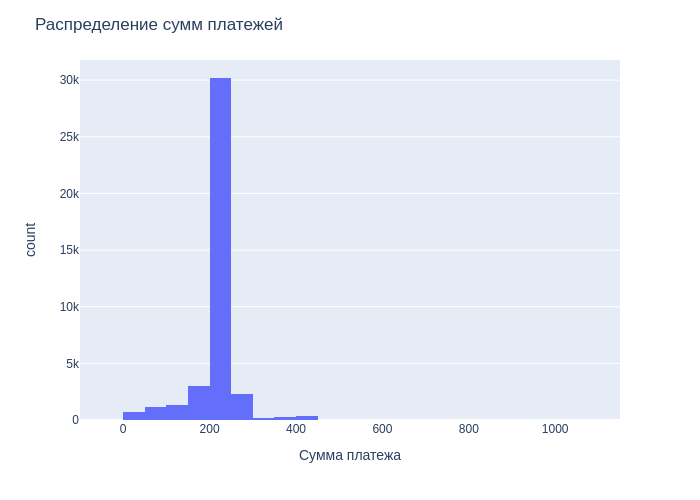

In [137]:
fig = px.histogram(
    payments_sum_bu_ls,
    x='Сумма платежа',
    labels={'Сумма платежа': 'Сумма платежа'},
    nbins=50  # Количество бинов в гистограмме
)
fig.update_layout(title='Распределение сумм платежей')
# Сохранение статического изображения в формате PNG
fig.write_image("static_plot30.png")
# Отображение графика
fig.show()

Анализ показателей распределения сумм платежей:
- Среди общего количества активных пользователей, самая популярная сумма платяжа составляет 200-250. Таких платежей пришло примерно тридцать тысяч. 
- На втором месте чек в размере 150-200. Таких платежей пришло примерно три тысячи. 
- На третьем месте чек в размере 200-250. Таких платежей пришло примерно две тысячи триста.

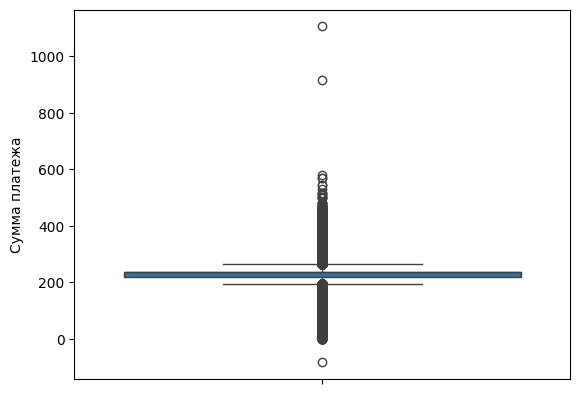

In [66]:
sns.boxplot(payments[payments['Источник платежа'].isin(col_list)].groupby('Лицевой счет (ЛС)')['Сумма платежа'].sum().reset_index()['Сумма платежа']);

Рассчитать для каждого ЛС плановую выручку с учетом дат начала услуг на ЛС и ставки тарифа

Для дальнейших расчетов нам потребуется объединить обе наши таблички в одну, по имеющимся в них лицевым счетам.

Но в начале убедимся в том, что все ли счета присутствуют в обеих таблицах:

In [67]:
len(set(list(offers['Лицевой счет (ЛС)'].unique())) - set(list(payments['Лицевой счет (ЛС)'].unique())))

1149

Видим что не все лицевые счета есть в платежках, попробуем разобраться

In [68]:
# список лицевых счетов отсутствующих в платежах
unnown_ls = set(list(offers['Лицевой счет (ЛС)'].unique())) - set(list(payments['Лицевой счет (ЛС)'].unique()))

In [69]:
# убеждаемся в этом еще раз
payments[payments['Лицевой счет (ЛС)'].isin(unnown_ls)].shape[0]

0

In [70]:
offers[offers['Лицевой счет (ЛС)'].isin(unnown_ls)]

,ИД дома,ИД подъезда,ИД квартиры,Лицевой счет (ЛС),Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц
28,105,691,23934,23934,ТО МКД,4.5,Отказ,2007-03-05,2007,3
72,105,1022,30187,30187,ТО МКД,4.5,Отказ,2007-05-25,2007,5
113,109,1120,32396,32396,ТО МКД,4.5,Отказ,2007-06-13,2007,6
124,109,1120,32409,32409,ТО МКД,4.5,Отказ,2007-06-13,2007,6
131,111,1550,41409,41409,ТО МКД,4.5,Отказ,2007-12-02,2007,12
...,...,...,...,...,...,...,...,...,...,...
49376,5218,1205,34170,48267,ТО МКД,5.4,Завершена,2007-07-11,2007,7
49427,5218,1205,34199,48268,ТО МКД,4.5,Завершена,2007-07-11,2007,7
49428,5218,1205,34199,48268,ТО СВОД,4.5,Отказ,2016-05-19,2016,5
49435,5218,1205,34203,48269,ТО СВОД,5.4,Не предоставляется,2016-05-19,2016,5


In [71]:
### смотрим самые популярные из услуг и статусов присутствуют у данных лицевых счетов
offers[offers['Лицевой счет (ЛС)'].isin(unnown_ls)].describe(include=['bool', 'object'])

,Услуга,Статус услуги
count,1339,1339
unique,3,4
top,ТО МКД,Отказ
freq,1146,1019


Видим что самая популярная позиция - это "Отказ", становится логично, почему данных счетов нет во второй табличке, но так же присутствуют еще 3 статуса у этих ЛС, попробуем визуализировать данные и разобраться

<Figure size 10000x3000 with 0 Axes>

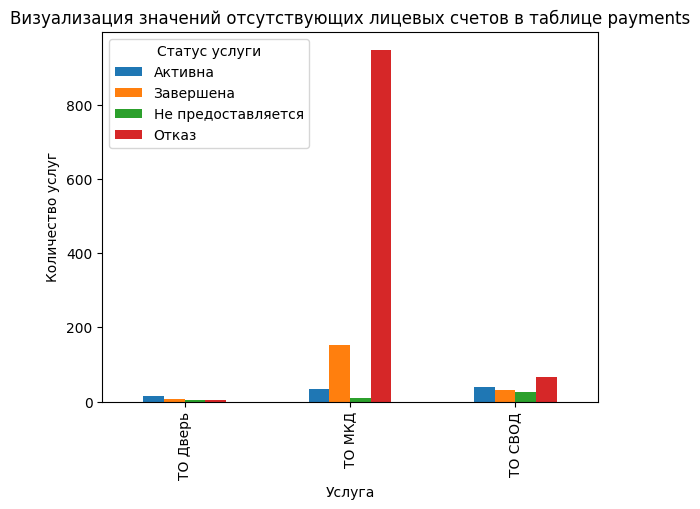

In [72]:
plt.figure(figsize=(100,30))
pd.crosstab(offers[offers['Лицевой счет (ЛС)'].isin(unnown_ls)]['Услуга'], 
            offers[offers['Лицевой счет (ЛС)'].isin(unnown_ls)]['Статус услуги']).plot(kind='bar', stacked=False)
plt.xlabel('Услуга')
plt.ylabel('Количество услуг')
plt.title('Визуализация значений отсутствующих лицевых счетов в таблице payments')
plt.show();

Как и предпологалось - большинство из них имеют статус "Отказ" или аналогичный по контексту, это объясняет и подтверждает нашу гипотезу отсутствия этих платежей в данных второй таблицы (не было оказано услуг - не было и платежей).

Но так же присутсвуют Активные услуги, взглянем на них более детально

In [73]:
offers[offers['Лицевой счет (ЛС)'].isin(unnown_ls)].query("`Статус услуги` == 'Активна'")

,ИД дома,ИД подъезда,ИД квартиры,Лицевой счет (ЛС),Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц
1190,166,1454,39358,39358,ТО МКД,5.4,Активна,2021-04-22,2021,4
2027,228,722,24553,24553,ТО СВОД,5.4,Активна,2018-04-13,2018,4
2319,233,92,3665,3665,ТО СВОД,5.0,Активна,2017-03-27,2017,3
2473,233,363,13785,13785,ТО СВОД,5.0,Активна,2020-03-02,2020,3
2600,233,1112,32145,32145,ТО СВОД,5.4,Активна,2017-03-27,2017,3
...,...,...,...,...,...,...,...,...,...,...
47697,5169,1762,46044,46044,ТО СВОД,5.4,Активна,2017-05-05,2017,5
47715,5169,1762,46053,46053,ТО СВОД,5.4,Активна,2017-05-05,2017,5
47940,5175,1758,45912,45912,ТО СВОД,5.4,Активна,2016-08-26,2016,8
48602,5195,1810,47117,46920,ТО МКД,5.4,Активна,2020-12-23,2020,12


In [74]:
suspect_data_no_pay = offers[offers['Лицевой счет (ЛС)'].isin(unnown_ls)].query("`Статус услуги` == 'Активна'")
suspect_data_no_pay.shape[0]

90

Гипотеза о том, что это совсем молодые заявки и у них еще только в переди первый платеж отпадает, исходя из колонки "Год".

90 ЛС с подозрительной активностью!

С этими ЛС рекоммендую разобраться более подробно, уточнить и проверить их статус активности и по какой причине присутствует такая путаница. Список этих ЛС приложу к финальному итогу проделанного анализа.

In [75]:
len(set(list(payments['Лицевой счет (ЛС)'].unique())) - set(list(offers['Лицевой счет (ЛС)'].unique())))

40

In [76]:
unnown_ls_pay = set(list(payments['Лицевой счет (ЛС)'].unique())) - set(list(offers['Лицевой счет (ЛС)'].unique()))

In [77]:
### так же убеждаемся в необходимых нам источниках платежей
suspect_data_unnoun_ls = payments[payments['Лицевой счет (ЛС)'].isin(unnown_ls_pay)]
suspect_data_unnoun_ls['Источник платежа'].unique()

array(['Ввод из реестра', 'Ручной ввод', 'Возврат'], dtype=object)

In [78]:
### На такую итоговую сумму поступили платежи с неизвестных лицевых счетов
suspect_data_unnoun_ls.groupby('Лицевой счет (ЛС)')['Сумма платежа'].sum().sum()

487.202

Видим также обратное: наличие Лицевых счетов в платежах и их полное отсутствие в таблице услуг.
Моя гипотеза - ошибка в запросах выборки или недозаполненность таблиц. В любом случае, обзор списка этих Лицевых счетов без детальной информации представляет определенные трудности.

Список с этими данными приложу так же в финальном выводе.

### Теперь объединим наши данные:

In [79]:
global_data = pd.merge(payments, offers, on='Лицевой счет (ЛС)', how='inner')

In [80]:
global_data.isna().sum()

Лицевой счет (ЛС)             0
Сумма платежа                 0
Дата загрузки                 0
Источник платежа              0
способ оплаты                 0
Комментарий к платежу    406849
ИД дома                       0
ИД подъезда                   0
ИД квартиры                   0
Услуга                        0
Ставка тарифа                 0
Статус услуги                 0
Дата начала услуги            0
Год                           0
Месяц                         0
dtype: int64

In [81]:
global_data.head(1)

,Лицевой счет (ЛС),Сумма платежа,Дата загрузки,Источник платежа,способ оплаты,Комментарий к платежу,ИД дома,ИД подъезда,ИД квартиры,Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц
0,1,4.8,2019-04-16,Ручной ввод,Офис,NaN,1662,1,1,ТО МКД,5.4,Завершена,2006-09-02,2006,9


In [82]:
global_data['Год_Загрузки'] = global_data['Дата загрузки'].dt.year
global_data['Месяц_Загрузки'] = global_data['Дата загрузки'].dt.month

In [ ]:


_list = []
### для каждого уникального ЛС
for ls in tqdm(global_data['Лицевой счет (ЛС)'].unique()):
    ### для каждой уникальной услуги
    for usl in global_data[global_data['Лицевой счет (ЛС)'] == ls]['Услуга'].unique():
        ### для каждой уникальной ставки
        for stavk in global_data.loc[(
            (global_data['Лицевой счет (ЛС)'] == ls) & 
            (global_data['Услуга'] == usl))]['Ставка тарифа'].unique():
            ### для каждого уникального статуса
            for stats in global_data.loc[(
                (global_data['Лицевой счет (ЛС)'] == ls) & 
                (global_data['Услуга'] == usl) &
                (global_data['Ставка тарифа'] == stavk))]['Статус услуги'].unique():

                

                _list.append([ls, 
                                   usl, 
                                   stavk, 
                                   global_data.loc[((global_data['Лицевой счет (ЛС)'] == ls) &
                                                                    (global_data['Услуга'] == usl) &
                                                                    (global_data['Ставка тарифа'] == stavk) &
                                                                    (global_data['Статус услуги'] == stats))]['Год_Загрузки'].max(), 
                                   global_data.loc[((global_data['Лицевой счет (ЛС)'] == ls) & 
                                                    (global_data['Услуга'] == usl) &
                                                    (global_data['Ставка тарифа'] == stavk) &
                                                    (global_data['Статус услуги'] == stats))]['Месяц_Загрузки'].max(),
                                   global_data.loc[((global_data['Лицевой счет (ЛС)'] == ls) & 
                                                    (global_data['Услуга'] == usl) &
                                                    (global_data['Ставка тарифа'] == stavk) &
                                                    (global_data['Статус услуги'] == stats))]['Год'].iloc[0],
                                   global_data.loc[((global_data['Лицевой счет (ЛС)'] == ls) & 
                                                    (global_data['Услуга'] == usl) &
                                                    (global_data['Ставка тарифа'] == stavk) &
                                                    (global_data['Статус услуги'] == stats))]['Месяц'].iloc[0],
                                   global_data.loc[((global_data['Лицевой счет (ЛС)'] == ls) & 
                                                    (global_data['Услуга'] == usl) &
                                                    (global_data['Ставка тарифа'] == stavk) &
                                                    (global_data['Статус услуги'] == stats))]['Статус услуги'].iloc[0]])

df = pd.DataFrame(_list, columns=['Лицевой счет (ЛС)', 
                                  'Услуга', 
                                  'Ставка тарифа', 
                                  'Год_последнего_платежа', 
                                  'Месяц_Посл', 
                                  'Год_нач', 
                                  'Месяц_нач',
                                  'Статус'])                

In [83]:
import joblib

### joblib.dump(df, 'metrics_df.pkl')
df = joblib.load('metrics_df.pkl')

In [84]:
df['Год_последнего_платежа'].unique()

array([2020, 2021, 2019, 2018], dtype=int32)

In [85]:
global_data

,Лицевой счет (ЛС),Сумма платежа,Дата загрузки,Источник платежа,способ оплаты,Комментарий к платежу,ИД дома,ИД подъезда,ИД квартиры,Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц,Год_Загрузки,Месяц_Загрузки
0,1,4.80,2019-04-16,Ручной ввод,Офис,NaN,1662,1,1,ТО МКД,5.4,Завершена,2006-09-02,2006,9,2019,4
1,1,4.80,2019-04-16,Ручной ввод,Офис,NaN,1662,1,1,ТО МКД,5.2,Активна,2021-03-01,2021,3,2019,4
2,1,4.80,2019-04-16,Ручной ввод,Офис,NaN,1662,1,1,ТО Дверь,5.0,Завершена,2020-01-01,2020,1,2019,4
3,1,14.40,2018-10-17,Ввод из реестра,Сбербанк России,NaN,1662,1,1,ТО МКД,5.4,Завершена,2006-09-02,2006,9,2018,10
4,1,14.40,2018-10-17,Ввод из реестра,Сбербанк России,NaN,1662,1,1,ТО МКД,5.2,Активна,2021-03-01,2021,3,2018,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413896,49150,25.81,2021-06-10,Ручной ввод,Выписки,NaN,4752,59,2376,ТО МКД,5.4,Активна,2021-02-02,2021,2,2021,6
413897,49151,20.63,2021-04-16,Ввод из реестра,Сбербанк России,NaN,1111,332,12626,ТО МКД,5.4,Завершена,2006-12-23,2006,12,2021,4
413898,49151,20.63,2021-04-16,Ввод из реестра,Сбербанк России,NaN,1111,332,12626,ТО МКД,5.4,Активна,2021-03-02,2021,3,2021,4
413899,49151,45.00,2021-07-07,Ручной ввод,Выписки,NaN,1111,332,12626,ТО МКД,5.4,Завершена,2006-12-23,2006,12,2021,7


In [86]:
df

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус
0,1,ТО МКД,5.4,2020,12,2006,9,Завершена
1,1,ТО МКД,5.2,2020,12,2021,3,Активна
2,1,ТО Дверь,5.0,2020,12,2020,1,Завершена
3,2,ТО МКД,5.2,2020,12,2007,10,Активна
4,3,ТО МКД,5.4,2021,11,2006,9,Активна
...,...,...,...,...,...,...,...,...
48185,49149,ТО МКД,5.4,2021,4,2020,12,Активна
48186,49150,ТО МКД,5.4,2021,6,2006,10,Завершена
48187,49150,ТО МКД,5.4,2021,6,2021,2,Активна
48188,49151,ТО МКД,5.4,2021,7,2006,12,Завершена


In [87]:
df['Статус'].unique()

array(['Завершена', 'Активна', 'Отказ', 'Не предоставляется',
       'Приостановлена', 'Будет активна', 'Не обслуживается'],
      dtype=object)

Добавим колонку, где для каждого Лс будет видно количество месяцев, за которые необходимо будет проводить дальнейшие расчеты.

Для Активных и остальных статусов они будут считаться по разному, для Активных мы берем полный период с 01.01.2018 по 13.10.2021,
а для остальных возмем конечным месяцем дату последнего патежа

In [88]:
df['Начало_периода'] = df['Год_нач'].apply(lambda x: 2018 if x < 2018 else x)

In [89]:
df['Начальный_месяц'] = df.apply(lambda row: row['Месяц_нач'] if row['Год_нач'] > 2018 else 1, axis=1)

In [90]:
df

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус,Начало_периода,Начальный_месяц
0,1,ТО МКД,5.4,2020,12,2006,9,Завершена,2018,1
1,1,ТО МКД,5.2,2020,12,2021,3,Активна,2021,3
2,1,ТО Дверь,5.0,2020,12,2020,1,Завершена,2020,1
3,2,ТО МКД,5.2,2020,12,2007,10,Активна,2018,1
4,3,ТО МКД,5.4,2021,11,2006,9,Активна,2018,1
...,...,...,...,...,...,...,...,...,...,...
48185,49149,ТО МКД,5.4,2021,4,2020,12,Активна,2020,12
48186,49150,ТО МКД,5.4,2021,6,2006,10,Завершена,2018,1
48187,49150,ТО МКД,5.4,2021,6,2021,2,Активна,2021,2
48188,49151,ТО МКД,5.4,2021,7,2006,12,Завершена,2018,1


In [91]:
### Для всех остальных статусов
df['Месяцев_с_начала'] = np.nan

mask = (df['Статус'] != 'Активна')

df.loc[mask, 'Месяцев_с_начала'] = df.loc[mask, 'Месяцев_с_начала'].fillna(
    (df.loc[mask, 'Год_последнего_платежа'] - df.loc[mask, 'Начало_периода']) * 12 + (
        df.loc[mask, 'Месяц_Посл'] - df.loc[mask, 'Начальный_месяц']
    )
)

### для активных
mask = (df['Статус'] == 'Активна')

df.loc[mask, 'Месяцев_с_начала'] = df.loc[mask, 'Месяцев_с_начала'].fillna(
    (2021- df.loc[mask, 'Начало_периода']) * 12 + (
        10 - df.loc[mask, 'Начальный_месяц']
    )
)

In [92]:
df

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус,Начало_периода,Начальный_месяц,Месяцев_с_начала
0,1,ТО МКД,5.4,2020,12,2006,9,Завершена,2018,1,35.0
1,1,ТО МКД,5.2,2020,12,2021,3,Активна,2021,3,7.0
2,1,ТО Дверь,5.0,2020,12,2020,1,Завершена,2020,1,11.0
3,2,ТО МКД,5.2,2020,12,2007,10,Активна,2018,1,45.0
4,3,ТО МКД,5.4,2021,11,2006,9,Активна,2018,1,45.0
...,...,...,...,...,...,...,...,...,...,...,...
48185,49149,ТО МКД,5.4,2021,4,2020,12,Активна,2020,12,10.0
48186,49150,ТО МКД,5.4,2021,6,2006,10,Завершена,2018,1,41.0
48187,49150,ТО МКД,5.4,2021,6,2021,2,Активна,2021,2,8.0
48188,49151,ТО МКД,5.4,2021,7,2006,12,Завершена,2018,1,42.0


Теперь рассчитаем плановую вырочку:

Но для начала нам нужно поменять тарифную ставку -10. на медианную по тарифу ВБ для корректных расчетов плановой выручки

In [93]:
df[df['Услуга'] == 'ВБ']['Ставка тарифа'].median()

4.5

In [94]:
df['Ставка тарифа'].unique()

array([  5.4,   5.2,   5. , -10. ,   4.5,   4. ,   4.7,   4.3,   4.8,
         5.6,   9.7])

In [95]:
df['Ставка тарифа'] = df.apply(
    lambda row: df[df['Услуга'] == 'ВБ']['Ставка тарифа'].median() if row['Ставка тарифа'] < 0 else row['Ставка тарифа'], axis=1)

global_data['Ставка тарифа'] = global_data.apply(
    lambda row: df[df['Услуга'] == 'ВБ']['Ставка тарифа'].median() if row['Ставка тарифа'] < 0 else row['Ставка тарифа'], axis=1)

In [96]:
df['Ставка тарифа'].unique()

array([5.4, 5.2, 5. , 4.5, 4. , 4.7, 4.3, 4.8, 5.6, 9.7])

In [97]:
df['Плановая_выручка'] = df['Месяцев_с_начала'] * df['Ставка тарифа']

In [98]:
df[df['Месяцев_с_начала'] <0]

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус,Начало_периода,Начальный_месяц,Месяцев_с_начала,Плановая_выручка
409,384,ТО Дверь,5.0,2019,12,2020,4,Завершена,2020,4,-4.0,-20.0
583,490,ТО Дверь,5.0,2018,11,2019,10,Не предоставляется,2019,10,-11.0,-55.0
8875,7639,ТО Дверь,5.0,2020,1,2020,12,Не предоставляется,2020,12,-11.0,-55.0
9432,8114,ТО Дверь,5.4,2019,12,2021,4,Завершена,2021,4,-16.0,-86.4
9691,8313,ТО Дверь,5.0,2019,6,2019,7,Не предоставляется,2019,7,-1.0,-5.0
12691,11258,ТО Дверь,5.4,2019,4,2019,6,Не предоставляется,2019,6,-2.0,-10.8
14062,12614,ТО Дверь,5.4,2019,10,2020,9,Не предоставляется,2020,9,-11.0,-59.4
16736,15038,ТО Дверь,5.4,2019,11,2021,4,Не предоставляется,2021,4,-17.0,-91.8
19015,17238,ТО СВОД,5.4,2020,9,2020,11,Не предоставляется,2020,11,-2.0,-10.8
19705,17908,ТО Дверь,5.0,2019,9,2019,10,Не предоставляется,2019,10,-1.0,-5.0


На лицо ошибка в первоначальнном заполнении, т.к. Год начала из первой таблички не соответствует и больше года последнего платежа.
добавим эти данные в отдельный файл с аномалиями.

In [99]:
unnormal_data = df[df['Месяцев_с_начала'] <0]
df = df[df['Месяцев_с_начала'] >=0].reset_index(drop=True)

In [100]:
df[df['Плановая_выручка'] <0]

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус,Начало_периода,Начальный_месяц,Месяцев_с_начала,Плановая_выручка


Видим что минусовой выручки в данных нет.

In [101]:
unnormal_data.reset_index(drop=True)

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус,Начало_периода,Начальный_месяц,Месяцев_с_начала,Плановая_выручка
0,384,ТО Дверь,5.0,2019,12,2020,4,Завершена,2020,4,-4.0,-20.0
1,490,ТО Дверь,5.0,2018,11,2019,10,Не предоставляется,2019,10,-11.0,-55.0
2,7639,ТО Дверь,5.0,2020,1,2020,12,Не предоставляется,2020,12,-11.0,-55.0
3,8114,ТО Дверь,5.4,2019,12,2021,4,Завершена,2021,4,-16.0,-86.4
4,8313,ТО Дверь,5.0,2019,6,2019,7,Не предоставляется,2019,7,-1.0,-5.0
5,11258,ТО Дверь,5.4,2019,4,2019,6,Не предоставляется,2019,6,-2.0,-10.8
6,12614,ТО Дверь,5.4,2019,10,2020,9,Не предоставляется,2020,9,-11.0,-59.4
7,15038,ТО Дверь,5.4,2019,11,2021,4,Не предоставляется,2021,4,-17.0,-91.8
8,17238,ТО СВОД,5.4,2020,9,2020,11,Не предоставляется,2020,11,-2.0,-10.8
9,17908,ТО Дверь,5.0,2019,9,2019,10,Не предоставляется,2019,10,-1.0,-5.0


In [102]:
df

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус,Начало_периода,Начальный_месяц,Месяцев_с_начала,Плановая_выручка
0,1,ТО МКД,5.4,2020,12,2006,9,Завершена,2018,1,35.0,189.0
1,1,ТО МКД,5.2,2020,12,2021,3,Активна,2021,3,7.0,36.4
2,1,ТО Дверь,5.0,2020,12,2020,1,Завершена,2020,1,11.0,55.0
3,2,ТО МКД,5.2,2020,12,2007,10,Активна,2018,1,45.0,234.0
4,3,ТО МКД,5.4,2021,11,2006,9,Активна,2018,1,45.0,243.0
...,...,...,...,...,...,...,...,...,...,...,...,...
48168,49149,ТО МКД,5.4,2021,4,2020,12,Активна,2020,12,10.0,54.0
48169,49150,ТО МКД,5.4,2021,6,2006,10,Завершена,2018,1,41.0,221.4
48170,49150,ТО МКД,5.4,2021,6,2021,2,Активна,2021,2,8.0,43.2
48171,49151,ТО МКД,5.4,2021,7,2006,12,Завершена,2018,1,42.0,226.8


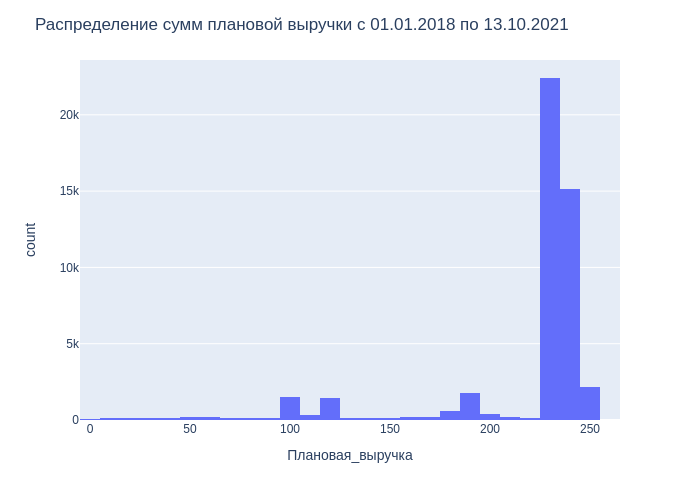

In [138]:
fig = px.histogram(
    df,
    x='Плановая_выручка',
    labels={'Плановая_выручка': 'Плановая_выручка'},
    nbins=50  # Количество бинов в гистограмме
)

fig.update_layout(title='Распределение сумм плановой выручки с 01.01.2018 по 13.10.2021')
# Сохранение статического изображения в формате PNG
fig.write_image("plot5.png")
fig.show()

Как видно из графика - средний платеж по плановой выручке у большинства клиентов должен быть в районе 225-250. 

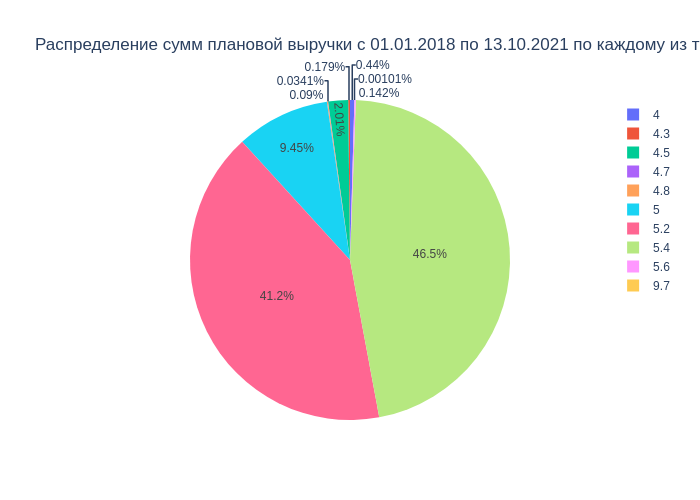

In [139]:
fig = go.Figure()
fig.add_trace(go.Pie(
    labels=df['Ставка тарифа'].value_counts().sort_index(ascending=True).index,
    values=df.groupby('Ставка тарифа')['Плановая_выручка'].sum().sort_index(ascending=True),
    sort=False
))
fig.update_layout(title="Распределение сумм плановой выручки с 01.01.2018 по 13.10.2021 по каждому из тарифов")
# Сохранение статического изображения в формате PNG
fig.write_image("static_plot31.png")
fig.show()

Самый популярный тариф - это 5.4, но не стоит забывать, что у нас есть определенное количество клиентов с рассрочкой и их платежи составляют значимую часть по этому тарифу. Учитывая что он был выбран средним и рекомендуется уточнить по каким именно тарифным планам действует рассрочка у клиентов(можно еще было составить ML модель и что бы она тоже подсчитала рекомендованный для них тариф, но в указанные сроки дедлайна - это невыполнимое задание, учитывая выборку и время на обучение модели)

В любом случае информацию по тарифным планам при рассрочках нужно уточнять у ответственных лиц.

Теперь сделаем чистый датасет, без наличия артефактов:

In [105]:
clear_data = global_data[global_data['Лицевой счет (ЛС)'].isin(list(df['Лицевой счет (ЛС)']))]

In [106]:
global_data[global_data['Лицевой счет (ЛС)'].isin(list(df['Лицевой счет (ЛС)']))].shape

(413899, 17)

In [107]:
global_data

,Лицевой счет (ЛС),Сумма платежа,Дата загрузки,Источник платежа,способ оплаты,Комментарий к платежу,ИД дома,ИД подъезда,ИД квартиры,Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц,Год_Загрузки,Месяц_Загрузки
0,1,4.80,2019-04-16,Ручной ввод,Офис,NaN,1662,1,1,ТО МКД,5.4,Завершена,2006-09-02,2006,9,2019,4
1,1,4.80,2019-04-16,Ручной ввод,Офис,NaN,1662,1,1,ТО МКД,5.2,Активна,2021-03-01,2021,3,2019,4
2,1,4.80,2019-04-16,Ручной ввод,Офис,NaN,1662,1,1,ТО Дверь,5.0,Завершена,2020-01-01,2020,1,2019,4
3,1,14.40,2018-10-17,Ввод из реестра,Сбербанк России,NaN,1662,1,1,ТО МКД,5.4,Завершена,2006-09-02,2006,9,2018,10
4,1,14.40,2018-10-17,Ввод из реестра,Сбербанк России,NaN,1662,1,1,ТО МКД,5.2,Активна,2021-03-01,2021,3,2018,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413896,49150,25.81,2021-06-10,Ручной ввод,Выписки,NaN,4752,59,2376,ТО МКД,5.4,Активна,2021-02-02,2021,2,2021,6
413897,49151,20.63,2021-04-16,Ввод из реестра,Сбербанк России,NaN,1111,332,12626,ТО МКД,5.4,Завершена,2006-12-23,2006,12,2021,4
413898,49151,20.63,2021-04-16,Ввод из реестра,Сбербанк России,NaN,1111,332,12626,ТО МКД,5.4,Активна,2021-03-02,2021,3,2021,4
413899,49151,45.00,2021-07-07,Ручной ввод,Выписки,NaN,1111,332,12626,ТО МКД,5.4,Завершена,2006-12-23,2006,12,2021,7


In [108]:
clear_data.head(1)

,Лицевой счет (ЛС),Сумма платежа,Дата загрузки,Источник платежа,способ оплаты,Комментарий к платежу,ИД дома,ИД подъезда,ИД квартиры,Услуга,Ставка тарифа,Статус услуги,Дата начала услуги,Год,Месяц,Год_Загрузки,Месяц_Загрузки
0,1,4.8,2019-04-16,Ручной ввод,Офис,NaN,1662,1,1,ТО МКД,5.4,Завершена,2006-09-02,2006,9,2019,4


In [109]:
clear_data.groupby('Год_Загрузки')['Сумма платежа'].sum()

Год_Загрузки
2018    2530516.234
2019    3518732.249
2020    2873150.587
2021    1506675.735
Name: Сумма платежа, dtype: float64

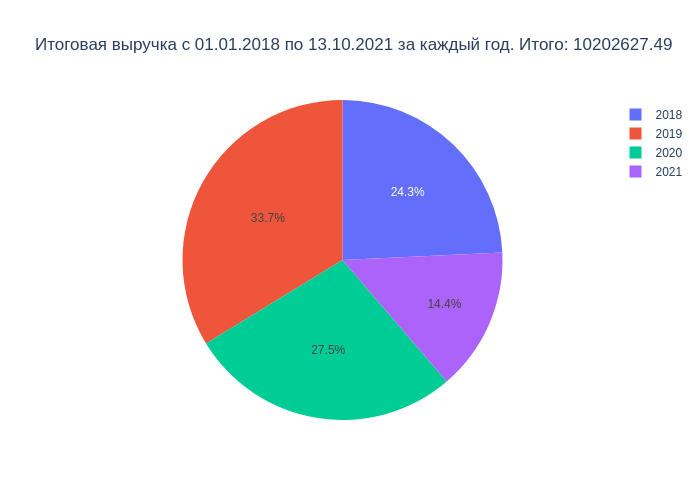

In [141]:
fig = go.Figure()
fig.add_trace(go.Pie(
    labels=clear_data['Год_Загрузки'].value_counts().sort_index(ascending=True).index,
    values=clear_data.groupby('Год_Загрузки')['Сумма платежа'].sum().sort_index(ascending=True),
    sort=False
))
fig.update_layout(title=f"Итоговая выручка с 01.01.2018 по 13.10.2021 за каждый год. Итого: {round(clear_data[clear_data['Источник платежа'].isin(col_list)].groupby('Год_Загрузки')['Сумма платежа'].sum().sum(),2)}")
# Сохранение статического изображения в формате PNG
fig.write_image("static_plot33.png")
fig.show()

Как видим большая часть выручки (примерно в равных долях) относится к интервалу 18-20 годов, что подтверждает нашу гипотезу про общий карантин, связанный с короновирусом.
Однако следует отметить самый прибыльный 2019 год.

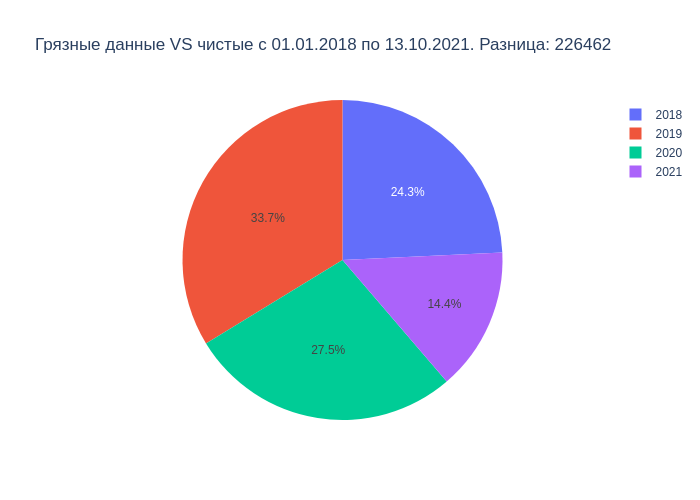

In [144]:
fig = go.Figure()
fig.add_trace(go.Pie(
    labels=global_data['Год_Загрузки'].value_counts().sort_index(ascending=True).index,
    values=global_data.groupby('Год_Загрузки')['Сумма платежа'].sum().sort_index(ascending=True),
    sort=False
))
fig.update_layout(title=f"Грязные данные VS чистые с 01.01.2018 по 13.10.2021. Разница: {round(round(global_data.groupby('Год_Загрузки')['Сумма платежа'].sum().sum(),2) - round(clear_data[clear_data['Источник платежа'].isin(col_list)].groupby('Год_Загрузки')['Сумма платежа'].sum().sum(),2))}")
# Сохранение статического изображения в формате PNG
fig.write_image("static_plot77.png")
fig.show()

Видим что разница колоссальная, что подчеркивает ценность и информативность наших гипотез, а так же необходимость уточнение предоставленной мной информации у ответственных за это лиц. Хотя в целом динамика такая же, как и у очищенных мной данных.

In [112]:
exit_data = pd.DataFrame(columns=['Плановая_выручка', 'Сумма платежа', 'Cальдо'])
exit_data['Сумма платежа'] = clear_data[clear_data['Источник платежа'].isin(col_list)].groupby('Лицевой счет (ЛС)')['Сумма платежа'].sum().sort_index()
exit_data['Плановая_выручка'] = df.groupby('Лицевой счет (ЛС)')['Плановая_выручка'].sum()
exit_data['Cальдо'] = exit_data['Плановая_выручка'] - exit_data['Сумма платежа']
exit_data = exit_data.reset_index()

In [113]:
exit_data

,Лицевой счет (ЛС),Плановая_выручка,Сумма платежа,Cальдо
0,1,280.4,547.20,-266.80
1,2,234.0,914.40,-680.40
2,3,243.0,230.40,12.60
3,4,234.0,236.40,-2.40
4,5,243.0,577.90,-334.90
...,...,...,...,...
39584,49146,52.0,62.40,-10.40
39585,49148,54.0,31.20,22.80
39586,49149,54.0,31.20,22.80
39587,49150,264.6,51.62,212.98


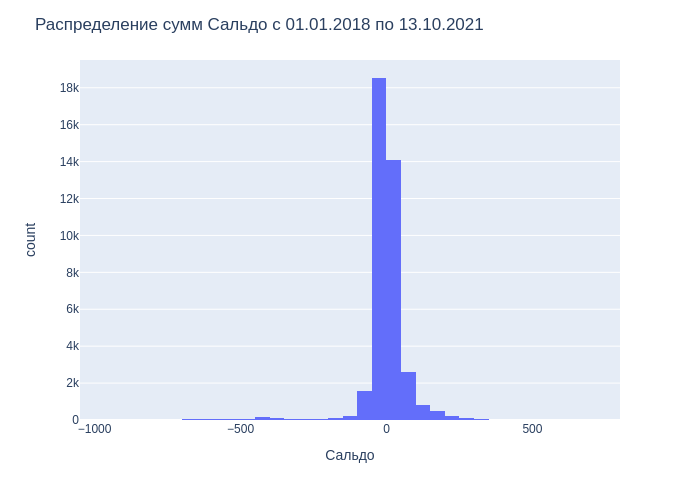

In [145]:
fig = px.histogram(
    exit_data,
    x='Cальдо',
    labels={'Cальдо': 'Cальдо'},
    nbins=50  # Количество бинов в гистограмме
)

fig.update_layout(title='Распределение сумм Cальдо с 01.01.2018 по 13.10.2021')
# Сохранение статического изображения в формате PNG
fig.write_image("static_plot78.png")
# Отображение графика
fig.show()

In [ ]:
_list = []
### 
for flat in tqdm(clear_data['ИД квартиры'].unique()):
    ### 
    for year in clear_data[clear_data['ИД квартиры'] == flat]['Год_Загрузки'].unique():
        ### 
        _list.append([
            flat, year, clear_data.loc[(
                                        (clear_data['ИД квартиры'] == flat) & 
                                        (clear_data['Год_Загрузки'] == year))]['Источник платежа'].count()])

In [ ]:
flat_data = pd.DataFrame(_list, columns=['ИД квартиры', 
                                  'Год_Загрузки',
                                  'Частота платежей'])

In [115]:
#joblib.dump(flat_data, 'flat_data.pkl')
flat_data = joblib.load('flat_data.pkl')

In [116]:
### табличка в которой для каждой квартиры есть частота платежей и количество оплаченных тарифов в календарный год
flat_data

,ИД квартиры,Год_Загрузки,Частота платежей
0,1,2019,6
1,1,2018,6
2,1,2020,6
3,2,2020,72
4,2,2018,1
...,...,...,...
137742,49550,2021,1
137743,49552,2021,1
137744,49553,2021,1
137745,2376,2021,2


In [117]:
flat_data.groupby(['Год_Загрузки'])['Частота платежей'].sum()

Год_Загрузки
2018     98657
2019    127833
2020    115538
2021     71871
Name: Частота платежей, dtype: int64

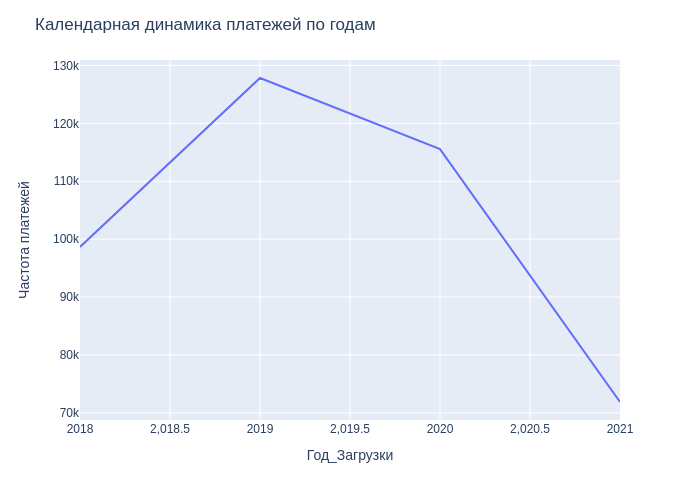

In [146]:
yearly_payments = flat_data.groupby(['Год_Загрузки'])['Частота платежей'].sum().reset_index()


fig = px.line(yearly_payments, x='Год_Загрузки', y='Частота платежей')

fig.update_layout(title='Календарная динамика платежей по годам')

# Сохранение статического изображения в формате PNG
fig.write_image("static_plot80.png")
fig.show()

Годовая динамика подтверждает наши гипотезы, описанные выше, т.к. в 2021м году наблюдается значительный спад частоты платежей.

<Figure size 10000x3000 with 0 Axes>

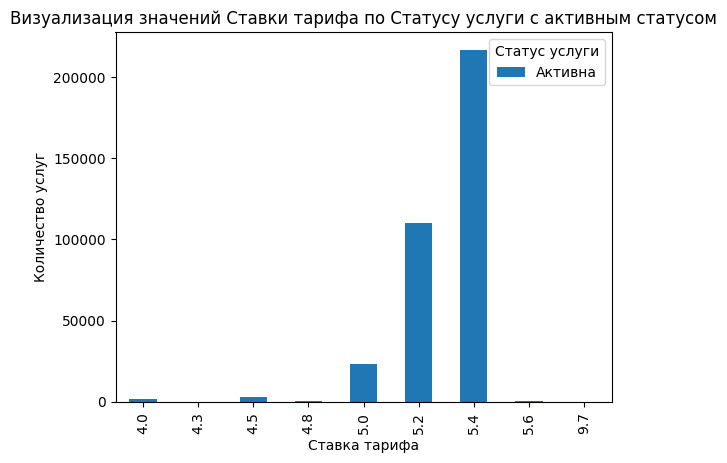

In [119]:
plt.figure(figsize=(100,30))
pd.crosstab(clear_data[clear_data['Статус услуги'] == 'Активна']['Ставка тарифа'], clear_data[clear_data['Статус услуги'] == 'Активна']['Статус услуги']).plot(kind='bar', stacked=False)
plt.xlabel('Ставка тарифа')
plt.ylabel('Количество услуг')
plt.title('Визуализация значений Ставки тарифа по Статусу услуги с активным статусом')
plt.show()

<Figure size 10000x3000 with 0 Axes>

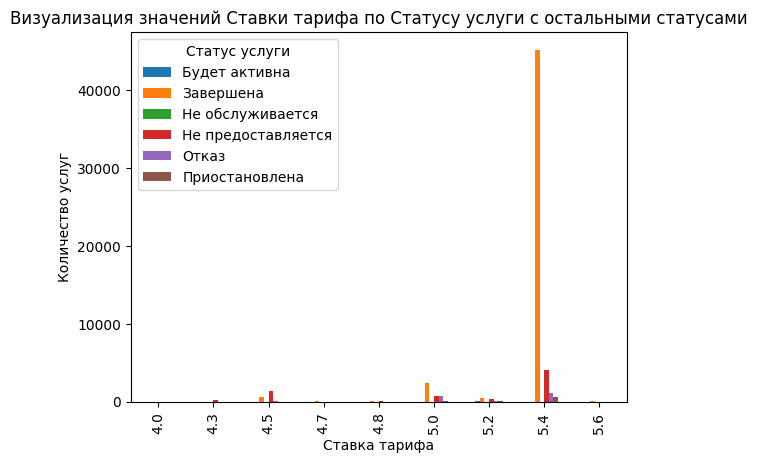

In [120]:
plt.figure(figsize=(100,30))
pd.crosstab(clear_data[clear_data['Статус услуги'] != 'Активна']['Ставка тарифа'], clear_data[clear_data['Статус услуги'] != 'Активна']['Статус услуги']).plot(kind='bar', stacked=False)
plt.xlabel('Ставка тарифа')
plt.ylabel('Количество услуг')
plt.title('Визуализация значений Ставки тарифа по Статусу услуги с остальными статусами')
plt.show();

Как видим - самый популярный тариф так же является лидером по количеству завершенных услуг, хотя в плане "качества лидирует тариф 5,2, т.к. у него второе место по числу активных ЛС и один из наименьших процентов отказов и завершенных". Рекомендуется присмотреться к нему по внмательнее, для возможной его переработки или наоборот его продвижения, в зависимости от нужд компании.

In [121]:
df

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус,Начало_периода,Начальный_месяц,Месяцев_с_начала,Плановая_выручка
0,1,ТО МКД,5.4,2020,12,2006,9,Завершена,2018,1,35.0,189.0
1,1,ТО МКД,5.2,2020,12,2021,3,Активна,2021,3,7.0,36.4
2,1,ТО Дверь,5.0,2020,12,2020,1,Завершена,2020,1,11.0,55.0
3,2,ТО МКД,5.2,2020,12,2007,10,Активна,2018,1,45.0,234.0
4,3,ТО МКД,5.4,2021,11,2006,9,Активна,2018,1,45.0,243.0
...,...,...,...,...,...,...,...,...,...,...,...,...
48168,49149,ТО МКД,5.4,2021,4,2020,12,Активна,2020,12,10.0,54.0
48169,49150,ТО МКД,5.4,2021,6,2006,10,Завершена,2018,1,41.0,221.4
48170,49150,ТО МКД,5.4,2021,6,2021,2,Активна,2021,2,8.0,43.2
48171,49151,ТО МКД,5.4,2021,7,2006,12,Завершена,2018,1,42.0,226.8


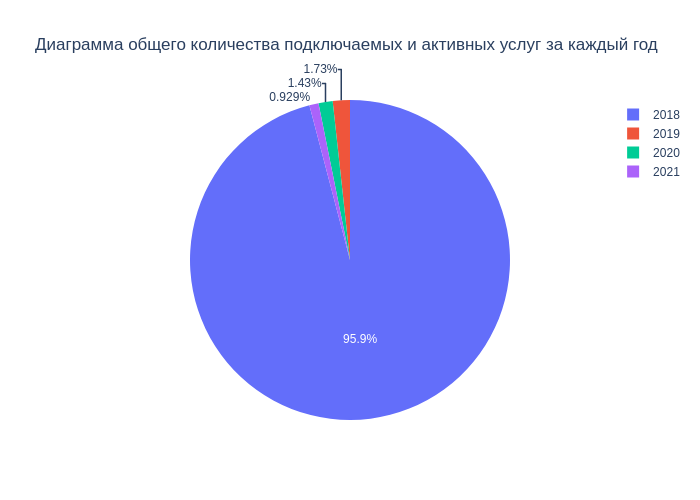

In [148]:
fig = go.Figure()
fig.add_trace(go.Pie(values=df[df['Статус'] == 'Активна']['Начало_периода'].value_counts().sort_index(ascending=True), 
                     labels=df[df['Статус'] == 'Активна']['Начало_периода'].value_counts().sort_index(ascending=True).index, 
                     sort = False))
fig.update_layout(title="Диаграмма общего количества подключаемых и активных услуг за каждый год")
# Сохранение статического изображения в формате PNG
fig.write_image("static_plot81.png")
fig.show()

Как видно из диаграммы - большинство клиентов старые и постоянные, как следствие - компания должна заботится об их удержании. Рекомендуется поговорить об этом с отделом маркетига и составить дальнейший возможный план действий.

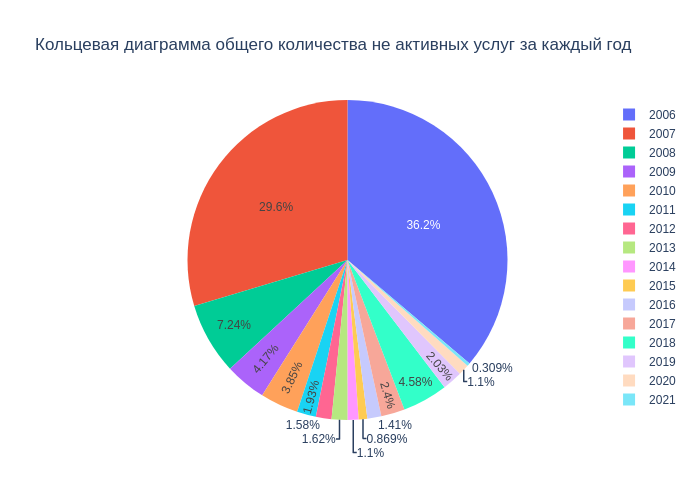

In [149]:
fig = go.Figure()
fig.add_trace(go.Pie(values=clear_data[clear_data['Статус услуги'] != 'Активна']['Год'].value_counts().sort_index(ascending=True), 
                     labels=clear_data[clear_data['Статус услуги'] != 'Активна']['Год'].value_counts().sort_index(ascending=True).index, 
                     sort = False))
fig.update_layout(title="Кольцевая диаграмма общего количества не активных услуг за каждый год")
# Сохранение статического изображения в формате PNG
fig.write_image("static_plot82.png")
fig.show()

Наблюдаем картину, что подавляющая часть завершенных услуг пришлась на конец 00х годов, что сказывается очень положительно на позицию клиенто-ориентированности компании в целом(каждый новый клиент - потенциально остается пользователем предоставляемых услуг на долгие годы).

In [124]:
_list = []
# 
for tarif in clear_data['Ставка тарифа'].unique():
    # 
    unique_statuses = clear_data.loc[clear_data['Ставка тарифа'] == tarif, 'Статус услуги'].unique()
    
    # 
    if len(unique_statuses) == 1 and unique_statuses[0] != 'Активна':
        _list.append(tarif)
print(f'Количество полностью не активных тарифов: {len(_list)}')

Количество полностью не активных тарифов: 0


#### Выводы:

In [125]:
print(f'Сумма плановой выручки: {round(df.groupby("Ставка тарифа")["Плановая_выручка"].sum().sum(), 2)},\nСумма итоговой выручки: {round(clear_data[clear_data["Источник платежа"].isin(col_list)].groupby("Год_Загрузки")["Сумма платежа"].sum().sum(), 2)},\nСумма Сальдо: {round(exit_data["Cальдо"].sum(), 2)}')

Сумма плановой выручки: 10581449.3,
Сумма итоговой выручки: 10202627.49,
Сумма Сальдо: 157394.21


В нашем случае Сальдо имеет положительное значение, что может указывать на то, что выручка превысила план. Однако стоит обратить пристальное внимание на предоставленные мной данные ниже, т.к. она должна быть еще больше(если разобраться и выполнить все рекомендации по неизвестным ЛС)

Исходя из проведенного анализа потребительской активности пользователей, мы выделили несколько ключевых тенденций и закономерностей.

1. Динамика активности по годам:

Период 2006-2007 годов характеризуется максимальной активностью, что свидетельствует о пиковой популярности услуги в тот период.
Аналитическим путем было установленно - в эти года чаще отказывались от услуг компании, чем в остальное обозреваемое время.

Снижение активности в 2011-2016 годах, вероятно, связано с уменьшением строительства новых многоквартирных домов.
Аналитическим путем было установленно - в эти годы компания уже набрала клиентскую базу и особой текучки клиентов в последствии не наблюдалось.

Резкое снижение активности в 2019-2021 годах может быть обусловлено влиянием пандемии COVID-19.

2. Анализ тарифов:

Тариф (5.2) - следует присмотреться к нему по внимательнее, т.к. он может оказаться не явным фаворитом у клиентов.

Тариф (5.4) - хоть и является самым популярным у клиентов, однако стоит обратить внимание на количество отказов и статуса завершен


3. Распределение сумм платежей:

Суммы платежей в диапазоне 200-250 являются наиболее распространенными, что может быть ключевым фактором при разработке новых тарифных планов.
Суммы в пределах 150-200 и 200-250 также заметны и могут представлять интерес для анализа поведения клиентов.
В целом, наши выводы предоставляют базовую основу для разработки стратегий по улучшению услуг, адаптации тарифов и эффективного взаимодействия с клиентами. Понимание динамики активности и предпочтений пользователей является важным инструментом для успешного развития и оптимизации предоставляемых услуг.

Аналитическое заключение:

Динамика выручки:

Большая часть выручки (примерно в равных долях) приходится на интервал 2018-2020 годов, что может быть связано с общим карантином, вызванным пандемией коронавируса.
Однако стоит выделить 2019 год как самый прибыльный.
Шумные данные и гипотезы:

Данные сильно зашумлены, что подчеркивает ценность и информативность гипотез.
Заметна колоссальная разница в данных, подчеркивающая необходимость уточнения предоставленной информации у ответственных за это лиц.
Динамика частоты платежей:

Годовая динамика подтверждает гипотезы, указывая на значительный спад частоты платежей в 2021 году.
Тарифы и завершенные услуги:

Самый популярный тариф также лидирует по количеству завершенных услуг.
Тариф 5,2, хотя не так популярен, обладает высоким "качеством" (второе место по активным ЛС и низкий процент отказов), что может потребовать дополнительного внимания для возможной переработки или продвижения.
Клиентская база:

Большинство клиентов являются старыми и постоянными, что подчеркивает важность удержания клиентов.
Рекомендуется обсудить этот вопрос с отделом маркетинга и разработать дальнейший план действий.
Завершенные услуги:

Заметно, что подавляющая часть завершенных услуг приходится на конец 00-х годов, что благоприятно влияет на клиенто-ориентированность компании, подчеркивая потенциальную долгосрочность клиентских отношений.
Общее заключение:
Анализ указывает на важность адаптации стратегии компании в ответ на изменения в поведении клиентов, уделяя внимание как удержанию постоянных клиентов, так и развитию новых возможностей в продвижении тарифов и услуг. Рекомендуется дополнительное исследование шумных данных и внимательное внедрение корректировок в стратегию на основе обнаруженных трендов.

Рассрочка и ее влияние:

Важно отметить, что существует определенное количество клиентов, использующих рассрочку, и их платежи составляют часть для тарифа 5.4.
Это может повлиять на итоговую картину о популярности тарифа, поскольку рассрочка может быть ключевым фактором для привлечения клиентов.
Уточнение по тарифным планам:

Рекомендуется уточнить, по каким именно тарифным планам предоставляется рассрочка для клиентов. Это позволит лучше понять влияние рассрочки на выбор тарифов и рассмотреть возможные стратегии для улучшения привлекательности тарифов.

ML-модель:
Упоминается возможность создания ML-модели для рекомендации тарифов клиентам с рассрочкой, но признается, что в рамках сроков дедлайна это невыполнимая задача.
Хотя идея применения ML интересна, понимание ограничений времени и выборки является реалистичным подходом.

Уточнение информации:
Завершающее заключение подчеркивает важность уточнения информации о тарифных планах при рассрочке у ответственных лиц.
Это позволит сформировать более точное представление о влиянии рассрочки на предпочтения клиентов и, возможно, определить стратегии для оптимизации предложений.

Анализ подчеркивает влияние рассрочки на выбор тарифов и необходимость более детального исследования в этом направлении. Уточнение информации у ответственных лиц и более глубокий анализ могут послужить основой для разработки стратегий по оптимизации предложений для клиентов, использующих рассрочку.

Прикрепленные данные:

In [126]:
# список лицевых счетов отсутствующих в платежах
len(unnown_ls)

1149

In [127]:
suspect_data_no_pay.shape 
### С этими ЛС рекоммендую разобраться более подробно, 
### уточнить и проверить их статус активности и по какой причине присутствует такая путаница.

(90, 10)

In [128]:
### На такую итоговую сумму поступили платежи с неизвестных лицевых счетов
suspect_data_unnoun_ls.groupby('Лицевой счет (ЛС)')['Сумма платежа'].sum().sum()

487.202

In [129]:
### Лс с гипотетически невенрым заполнением дат и абоненты не заплатившие услуги в расчетном периоде
unnormal_data.head(5)

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус,Начало_периода,Начальный_месяц,Месяцев_с_начала,Плановая_выручка
409,384,ТО Дверь,5.0,2019,12,2020,4,Завершена,2020,4,-4.0,-20.0
583,490,ТО Дверь,5.0,2018,11,2019,10,Не предоставляется,2019,10,-11.0,-55.0
8875,7639,ТО Дверь,5.0,2020,1,2020,12,Не предоставляется,2020,12,-11.0,-55.0
9432,8114,ТО Дверь,5.4,2019,12,2021,4,Завершена,2021,4,-16.0,-86.4
9691,8313,ТО Дверь,5.0,2019,6,2019,7,Не предоставляется,2019,7,-1.0,-5.0


In [130]:
### краткая выжимка по предоставленным данным
df.head()

,Лицевой счет (ЛС),Услуга,Ставка тарифа,Год_последнего_платежа,Месяц_Посл,Год_нач,Месяц_нач,Статус,Начало_периода,Начальный_месяц,Месяцев_с_начала,Плановая_выручка
0,1,ТО МКД,5.4,2020,12,2006,9,Завершена,2018,1,35.0,189.0
1,1,ТО МКД,5.2,2020,12,2021,3,Активна,2021,3,7.0,36.4
2,1,ТО Дверь,5.0,2020,12,2020,1,Завершена,2020,1,11.0,55.0
3,2,ТО МКД,5.2,2020,12,2007,10,Активна,2018,1,45.0,234.0
4,3,ТО МКД,5.4,2021,11,2006,9,Активна,2018,1,45.0,243.0


In [131]:
### Табличка с запрашиваемыми метриками
exit_data.head(5)

,Лицевой счет (ЛС),Плановая_выручка,Сумма платежа,Cальдо
0,1,280.4,547.2,-266.8
1,2,234.0,914.4,-680.4
2,3,243.0,230.4,12.6
3,4,234.0,236.4,-2.4
4,5,243.0,577.9,-334.9


In [132]:
### табличка в которой для каждой квартиры есть частота платежей и количество оплаченных тарифов в календарный год
flat_data.head(5)

,ИД квартиры,Год_Загрузки,Частота платежей
0,1,2019,6
1,1,2018,6
2,1,2020,6
3,2,2020,72
4,2,2018,1


Из-за строгого двухдневного дедлайна и необходимости более глубокого анализа предоставленных данных(по причине множественных артефактов), а также в связи с тем, что на данный момент это не моя основная деятельность (хотя у меня есть сильное желание изменить это, и я надеюсь, что вам понравится проведенный мной анализ и мы скоро увидимся с вами на моем рабочем месте в вашей компании). Прошу простить за мелкие недочеты и что ограничился более кратким общим выводом.
В целом постарался передать суть полной картины предоставленных мне данных, если требуется необходимость ее "отшлифовки" прошу предоставить мне чуть большие временные рамки.